# 제품 이상여부 판별 프로젝트 Display Defect Detection Project

- See the bottom for Eng. version.

본 코드의 수행과제는 디스플레이 제조과정 중 검사장비의 센서들을 통해 집계된 데이터에서 불량품을 예측하는 것입니다.
The task of this code is to predict defective products from data collected through sensors in inspection equipment during the display manufacturing process.

관련 지식이 있고 ipynb 문서를 여는 환경이 있을 경우, 본 파일을 다운받아서 Outline을 보시면 더 이해가 쉬울 것입니다. 
If you have relevant knowledge and an environment to open ipynb documents, downloading this file and viewing the 'Outline' will make it easier to understand.

[코드 개요]

데이터의 차원이 커 조금이라도 집약적으로 정보를 표현하려 했습니다. 먼저 x축, y축, z축이 따로 들어온 데이터를 3차원 좌표계에서 표현합니다. 그 후 가능한 한 변동이 큰 변수들 이외의 변수들을 제거합니다. (PCA, scree plot 사용) 변동이 작은 변수는 목표인 불량품 여부에 큰 영향을 미치지 않을 가능성이 크기 때문입니다.

또한 데이터가 불량품보다는 정상품이 훨씬 많은 불균형을 보이는데, 이러한 데이터에서는 예측이 어려울 수 있습니다. 따라서 정상품을 줄인 (Random Undersampling) 후, 줄어든 정상품만큼만 불량품을 늘려 (CTGAN) 정상품과 불량품 간 균형을 맞췄습니다.

위처럼 전처리 후 주로 정형데이터 (엑셀에서 흔히 보는 것처럼 구조화된 데이터)에서 강점을 보이고, 학습이 빠른 부스팅 모형을 중점으로 세부적인 부분들을 튜닝해가며 성능변화를 체크했습니다.

특정 시점 이후부터는 성능 향상에 한계가 있었기에, 자동화 모형 (Autogluon)을 사용하였습니다.

[Code Overview]

Due to the high dimensionality of the data, I attempted to represent information as concisely as possible. First, I represented data where x-axis, y-axis, and z-axis values came separately in a 3D coordinate system. Then, I removed variables with minimal variation, keeping only those with significant variation (using PCA and scree plot). Variables with little variation are likely to have minimal impact on determining product defects.

Additionally, the data shows an imbalance with far more normal products than defective ones, which can make prediction difficult. Therefore, I reduced the number of normal products (Random Undersampling) and then increased the defective products by the same amount (using CTGAN) to balance the classes.

After this preprocessing, I focused on boosting models that show strengths with structured data and offer fast learning. I checked performance changes while fine-tuning various detailed aspects.

After a certain point, there were limitations to performance improvements, so I employed an automated modeling approach (Autogluon).

## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import (
    # accuracy_score,
    # classification_report,
    # confusion_matrix,
    # f1_score,
    # precision_score,
    # recall_score,
# )
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# from google.colab import drive; drive.mount('/content/drive'); ROOT_DIR = "/content/drive/MyDrive/Projects/LG_Aimers_5th/Jongwu/Data"
ROOT_DIR = "data"
RANDOM_STATE = 110

### 데이터 읽어오기


In [131]:
# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

### Dealing with Coordinates

In [7]:
columns = train_data.columns.tolist()
for column in columns:
    print(f"'{column}',")

'Wip Line_Dam',
'Process Desc._Dam',
'Equipment_Dam',
'Model.Suffix_Dam',
'Workorder_Dam',
'Insp. Seq No._Dam',
'Insp Judge Code_Dam',
'CURE END POSITION X Collect Result_Dam',
'CURE END POSITION X Unit Time_Dam',
'CURE END POSITION X Judge Value_Dam',
'CURE END POSITION Z Collect Result_Dam',
'CURE END POSITION Z Unit Time_Dam',
'CURE END POSITION Z Judge Value_Dam',
'CURE END POSITION Θ Collect Result_Dam',
'CURE END POSITION Θ Unit Time_Dam',
'CURE END POSITION Θ Judge Value_Dam',
'CURE SPEED Collect Result_Dam',
'CURE SPEED Unit Time_Dam',
'CURE SPEED Judge Value_Dam',
'CURE STANDBY POSITION X Collect Result_Dam',
'CURE STANDBY POSITION X Unit Time_Dam',
'CURE STANDBY POSITION X Judge Value_Dam',
'CURE STANDBY POSITION Z Collect Result_Dam',
'CURE STANDBY POSITION Z Unit Time_Dam',
'CURE STANDBY POSITION Z Judge Value_Dam',
'CURE STANDBY POSITION Θ Collect Result_Dam',
'CURE STANDBY POSITION Θ Unit Time_Dam',
'CURE STANDBY POSITION Θ Judge Value_Dam',
'CURE START POSITION X Collect

In [22]:
Coordinate_columns = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Fill2',
'HEAD Standby Position X Collect Result_Fill2',
'HEAD Standby Position X Unit Time_Fill2',
'HEAD Standby Position X Judge Value_Fill2',
'HEAD Standby Position Y Collect Result_Fill2',
'HEAD Standby Position Y Unit Time_Fill2',
'HEAD Standby Position Y Judge Value_Fill2',
'HEAD Standby Position Z Collect Result_Fill2',
'HEAD Standby Position Z Unit Time_Fill2',
'HEAD Standby Position Z Judge Value_Fill2',
'Head Clean Position X Collect Result_Fill2',
'Head Clean Position X Unit Time_Fill2',
'Head Clean Position X Judge Value_Fill2',
'Head Clean Position Y Collect Result_Fill2',
'Head Clean Position Y Unit Time_Fill2',
'Head Clean Position Y Judge Value_Fill2',
'Head Clean Position Z Collect Result_Fill2',
'Head Clean Position Z Unit Time_Fill2',
'Head Clean Position Z Judge Value_Fill2',
'Head Purge Position X Collect Result_Fill2',
'Head Purge Position X Unit Time_Fill2',
'Head Purge Position X Judge Value_Fill2',
'Head Purge Position Y Collect Result_Fill2',
'Head Purge Position Y Unit Time_Fill2',
'Head Purge Position Y Judge Value_Fill2',
'Head Purge Position Z Collect Result_Fill2',
'Head Purge Position Z Unit Time_Fill2',
'Head Purge Position Z Judge Value_Fill2',
'CURE END POSITION X Collect Result_Fill2',
'CURE END POSITION X Unit Time_Fill2',
'CURE END POSITION X Judge Value_Fill2',
'CURE END POSITION Z Collect Result_Fill2',
'CURE END POSITION Z Unit Time_Fill2',
'CURE END POSITION Z Judge Value_Fill2',
'CURE END POSITION Θ Collect Result_Fill2',
'CURE END POSITION Θ Unit Time_Fill2',
'CURE END POSITION Θ Judge Value_Fill2',
'CURE STANDBY POSITION X Collect Result_Fill2',
'CURE STANDBY POSITION X Unit Time_Fill2',
'CURE STANDBY POSITION X Judge Value_Fill2',
'CURE STANDBY POSITION Z Collect Result_Fill2',
'CURE STANDBY POSITION Z Unit Time_Fill2',
'CURE STANDBY POSITION Z Judge Value_Fill2',
'CURE STANDBY POSITION Θ Collect Result_Fill2',
'CURE STANDBY POSITION Θ Unit Time_Fill2',
'CURE STANDBY POSITION Θ Judge Value_Fill2',
'CURE START POSITION X Collect Result_Fill2',
'CURE START POSITION X Unit Time_Fill2',
'CURE START POSITION X Judge Value_Fill2',
'CURE START POSITION Z Collect Result_Fill2',
'CURE START POSITION Z Unit Time_Fill2',
'CURE START POSITION Z Judge Value_Fill2',
'CURE START POSITION Θ Collect Result_Fill2',
'CURE START POSITION Θ Unit Time_Fill2',
'CURE START POSITION Θ Judge Value_Fill2',
'CURE END POSITION X Collect Result_Dam',
'CURE END POSITION X Unit Time_Dam',
'CURE END POSITION X Judge Value_Dam',
'CURE END POSITION Z Collect Result_Dam',
'CURE END POSITION Z Unit Time_Dam',
'CURE END POSITION Z Judge Value_Dam',
'CURE END POSITION Θ Collect Result_Dam',
'CURE END POSITION Θ Unit Time_Dam',
'CURE END POSITION Θ Judge Value_Dam',
'CURE STANDBY POSITION X Collect Result_Dam',
'CURE STANDBY POSITION X Unit Time_Dam',
'CURE STANDBY POSITION X Judge Value_Dam',
'CURE STANDBY POSITION Z Collect Result_Dam',
'CURE STANDBY POSITION Z Unit Time_Dam',
'CURE STANDBY POSITION Z Judge Value_Dam',
'CURE STANDBY POSITION Θ Collect Result_Dam',
'CURE STANDBY POSITION Θ Unit Time_Dam',
'CURE STANDBY POSITION Θ Judge Value_Dam',
'CURE START POSITION X Collect Result_Dam',
'CURE START POSITION X Unit Time_Dam',
'CURE START POSITION X Judge Value_Dam',
'CURE START POSITION Z Collect Result_Dam',
'CURE START POSITION Z Unit Time_Dam',
'CURE START POSITION Z Judge Value_Dam',
'CURE START POSITION Θ Collect Result_Dam',
'CURE START POSITION Θ Unit Time_Dam',
'CURE START POSITION Θ Judge Value_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Dam',
'HEAD Standby Position X Collect Result_Dam',
'HEAD Standby Position X Unit Time_Dam',
'HEAD Standby Position X Judge Value_Dam',
'HEAD Standby Position Y Collect Result_Dam',
'HEAD Standby Position Y Unit Time_Dam',
'HEAD Standby Position Y Judge Value_Dam',
'HEAD Standby Position Z Collect Result_Dam',
'HEAD Standby Position Z Unit Time_Dam',
'HEAD Standby Position Z Judge Value_Dam',
'Head Clean Position X Collect Result_Dam',
'Head Clean Position X Unit Time_Dam',
'Head Clean Position X Judge Value_Dam',
'Head Clean Position Y Collect Result_Dam',
'Head Clean Position Y Unit Time_Dam',
'Head Clean Position Y Judge Value_Dam',
'Head Clean Position Z Collect Result_Dam',
'Head Clean Position Z Unit Time_Dam',
'Head Clean Position Z Judge Value_Dam',
'Head Purge Position X Collect Result_Dam',
'Head Purge Position X Unit Time_Dam',
'Head Purge Position X Judge Value_Dam',
'Head Purge Position Y Collect Result_Dam',
'Head Purge Position Y Unit Time_Dam',
'Head Purge Position Y Judge Value_Dam',
'Head Purge Position Z Collect Result_Dam',
'Head Purge Position Z Unit Time_Dam',
'Head Purge Position Z Judge Value_Dam',
'Head Zero Position X Collect Result_Dam',
'Head Zero Position X Unit Time_Dam',
'Head Zero Position X Judge Value_Dam',
'Head Zero Position Y Collect Result_Dam',
'Head Zero Position Y Unit Time_Dam',
'Head Zero Position Y Judge Value_Dam',
'Head Zero Position Z Collect Result_Dam',
'Head Zero Position Z Unit Time_Dam',
'Head Zero Position Z Judge Value_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Fill1',
'HEAD Standby Position X Collect Result_Fill1',
'HEAD Standby Position X Unit Time_Fill1',
'HEAD Standby Position X Judge Value_Fill1',
'HEAD Standby Position Y Collect Result_Fill1',
'HEAD Standby Position Y Unit Time_Fill1',
'HEAD Standby Position Y Judge Value_Fill1',
'HEAD Standby Position Z Collect Result_Fill1',
'HEAD Standby Position Z Unit Time_Fill1',
'HEAD Standby Position Z Judge Value_Fill1',
'Head Clean Position X Collect Result_Fill1',
'Head Clean Position X Unit Time_Fill1',
'Head Clean Position X Judge Value_Fill1',
'Head Clean Position Y Collect Result_Fill1',
'Head Clean Position Y Unit Time_Fill1',
'Head Clean Position Y Judge Value_Fill1',
'Head Clean Position Z Collect Result_Fill1',
'Head Clean Position Z Unit Time_Fill1',
'Head Clean Position Z Judge Value_Fill1',
'Head Purge Position X Collect Result_Fill1',
'Head Purge Position X Unit Time_Fill1',
'Head Purge Position X Judge Value_Fill1',
'Head Purge Position Y Collect Result_Fill1',
'Head Purge Position Y Unit Time_Fill1',
'Head Purge Position Y Judge Value_Fill1',
'Head Purge Position Z Collect Result_Fill1',
'Head Purge Position Z Unit Time_Fill1',
'Head Purge Position Z Judge Value_Fill1']


### Spherical coordinate mapping + Target encoding

In [144]:
filtered_columns = Coordinate_columns

# Create a DataFrame with only the filtered columns
filtered_train_set = train_data[filtered_columns]
filtered_test_set = test_data[filtered_columns]

# Drop columns with more than one null value from the filtered DataFrame
filtered_train_set = filtered_train_set.dropna(axis=1, thresh=1)
filtered_test_set = filtered_test_set.dropna(axis=1, thresh=1)

# Print the filtered columns
print("The number of columns containing 'coordinate' or 'position':")
print(len(filtered_columns))
print("The name of columns")
print(filtered_columns)

The number of columns containing 'coordinate' or 'position':
225
The name of columns
['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Fill2', 'HEAD NORMAL COORDINATE 

In [145]:
all_columns = train_data.columns.tolist()
# all_columns = test_data.columns.tolist()

In [146]:
# Define a mapping dictionary to store coordinates
coordinate_mapping = {}
unmatched_columns = []

# Iterate through each column to categorize coordinates
for col in all_columns:
    # Identify the coordinate type first
    if ' X ' in col:
        coord_type = 'X'
    elif ' Y ' in col:
        coord_type = 'Y'
    elif ' Z ' in col:
        coord_type = 'Z'
    elif ' Θ ' in col:
        coord_type = 'Y'  # Treat Θ as Y for consistency
    else:
        coord_type = None

    # If a valid coordinate type is found, determine the category
    if coord_type:
        # Standardize category name by removing specific coordinate indicators
        category = col.replace(' X ', ' ').replace(' Y ', ' ').replace(' Z ', ' ').replace(' Θ ', ' ').strip()

        # Further clean up to standardize category names, keeping common phrases
        if "Collect Result" in col:
            category += " Collect Result"
        elif "Judge Value" in col:
            category += " Judge Value"

        # Add to mapping based on category and coordinate type
        if category not in coordinate_mapping:
            coordinate_mapping[category] = {}
        coordinate_mapping[category][coord_type] = col

# Prepare lists to store full groups, partial groups, and unmatched
full_groups = []
partial_groups = []
unmatched = []

# Simulate a DataFrame with some missing values
# Example:
# train_data = pd.read_csv('your_data.csv')

# Classify the results
for category, coords in coordinate_mapping.items():
    if len(coords) == 3:
        # Check for missing values in the full group
        columns_to_check = [coords['X'], coords['Y'], coords['Z']]
        if train_data[columns_to_check].isnull().any().any():  # Check if any column in the full group has missing values
            partial_groups.append((category, coords))
        else:
            full_groups.append((category, coords))
    elif len(coords) == 2:
        partial_groups.append((category, coords))
    else:
        unmatched.append((category, coords))

# Output results
print("\nFull Groups (X, Y, Z all present and no missing values):")
for category, coords in full_groups:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")

print("\nPartial Groups (includes those downgraded due to missing values):")
for category, coords in partial_groups:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")

print("\nUnmatched (less than 2 coordinates present):")
for category, coords in unmatched:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")



Full Groups (X, Y, Z all present and no missing values):
Category: CURE END POSITION Collect Result_Dam Collect Result
  X: CURE END POSITION X Collect Result_Dam
  Z: CURE END POSITION Z Collect Result_Dam
  Y: CURE END POSITION Θ Collect Result_Dam
Category: CURE STANDBY POSITION Collect Result_Dam Collect Result
  X: CURE STANDBY POSITION X Collect Result_Dam
  Z: CURE STANDBY POSITION Z Collect Result_Dam
  Y: CURE STANDBY POSITION Θ Collect Result_Dam
Category: CURE START POSITION Collect Result_Dam Collect Result
  X: CURE START POSITION X Collect Result_Dam
  Z: CURE START POSITION Z Collect Result_Dam
  Y: CURE START POSITION Θ Collect Result_Dam
Category: HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam Collect Result
  X: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
  Y: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
  Z: HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam
Category: HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam Colle

In [147]:
# Define a mapping dictionary to store coordinates
coordinate_mapping = {}
unmatched_columns = []

# Iterate through each column to categorize coordinates
for col in all_columns:
    # Identify the coordinate type first
    if ' X ' in col:
        coord_type = 'X'
    elif ' Y ' in col:
        coord_type = 'Y'
    elif ' Z ' in col:
        coord_type = 'Z'
    elif ' Θ ' in col:
        coord_type = 'Y'  # Treat Θ as Y for consistency
    else:
        coord_type = None

    # If a valid coordinate type is found, determine the category
    if coord_type:
        # Standardize category name by removing specific coordinate indicators
        category = col.replace(' X ', ' ').replace(' Y ', ' ').replace(' Z ', ' ').replace(' Θ ', ' ').strip()

        # Further clean up to standardize category names, keeping common phrases
        if "Collect Result" in col:
            category += " Collect Result"
        elif "Judge Value" in col:
            category += " Judge Value"

        # Add to mapping based on category and coordinate type
        if category not in coordinate_mapping:
            coordinate_mapping[category] = {}
        coordinate_mapping[category][coord_type] = col

# Prepare lists to store full groups, partial groups, and unmatched
full_groups = []
partial_groups = []
unmatched = []

# Simulate a DataFrame with some missing values
# Example:
# train_data = pd.read_csv('your_data.csv')

# Classify the results
for category, coords in coordinate_mapping.items():
    if len(coords) == 3:
        # Check for missing values in the full group
        columns_to_check = [coords['X'], coords['Y'], coords['Z']]
        if train_data[columns_to_check].isnull().any().any():  # Check if any column in the full group has missing values
            partial_groups.append((category, coords))
        else:
            full_groups.append((category, coords))
    elif len(coords) == 2:
        partial_groups.append((category, coords))
    else:
        unmatched.append((category, coords))

# Output results
print("\nFull Groups (X, Y, Z all present and no missing values):")
for category, coords in full_groups:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")

print("\nPartial Groups (includes those downgraded due to missing values):")
for category, coords in partial_groups:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")

print("\nUnmatched (less than 2 coordinates present):")
for category, coords in unmatched:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")



Full Groups (X, Y, Z all present and no missing values):
Category: CURE END POSITION Collect Result_Dam Collect Result
  X: CURE END POSITION X Collect Result_Dam
  Z: CURE END POSITION Z Collect Result_Dam
  Y: CURE END POSITION Θ Collect Result_Dam
Category: CURE STANDBY POSITION Collect Result_Dam Collect Result
  X: CURE STANDBY POSITION X Collect Result_Dam
  Z: CURE STANDBY POSITION Z Collect Result_Dam
  Y: CURE STANDBY POSITION Θ Collect Result_Dam
Category: CURE START POSITION Collect Result_Dam Collect Result
  X: CURE START POSITION X Collect Result_Dam
  Z: CURE START POSITION Z Collect Result_Dam
  Y: CURE START POSITION Θ Collect Result_Dam
Category: HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam Collect Result
  X: HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
  Y: HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
  Z: HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam
Category: HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam Colle

In [148]:
full_groups = []
partial_groups = []
unmatched = []

# Classify the results
for category, coords in coordinate_mapping.items():
    if len(coords) == 3:
        full_groups.append((category, coords))
    elif len(coords) == 2:
        partial_groups.append((category, coords))
    else:
        unmatched.append((category, coords))

# Output results
print("\nFull Groups (X, Y, Z all present):")
for category, coords in full_groups:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")

print("\nPartial Groups (less than 3 coordinates present):")
for category, coords in partial_groups:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")

print("\nUnmatched (less than 2 coordinates present):")
for category, coords in unmatched:
    print(f"Category: {category}")
    for coord_type, col_name in coords.items():
        print(f"  {coord_type}: {col_name}")


Full Groups (X, Y, Z all present):
Category: CURE END POSITION Collect Result_Dam Collect Result
  X: CURE END POSITION X Collect Result_Dam
  Z: CURE END POSITION Z Collect Result_Dam
  Y: CURE END POSITION Θ Collect Result_Dam
Category: CURE END POSITION Unit Time_Dam
  X: CURE END POSITION X Unit Time_Dam
  Z: CURE END POSITION Z Unit Time_Dam
  Y: CURE END POSITION Θ Unit Time_Dam
Category: CURE END POSITION Judge Value_Dam Judge Value
  X: CURE END POSITION X Judge Value_Dam
  Z: CURE END POSITION Z Judge Value_Dam
  Y: CURE END POSITION Θ Judge Value_Dam
Category: CURE STANDBY POSITION Collect Result_Dam Collect Result
  X: CURE STANDBY POSITION X Collect Result_Dam
  Z: CURE STANDBY POSITION Z Collect Result_Dam
  Y: CURE STANDBY POSITION Θ Collect Result_Dam
Category: CURE STANDBY POSITION Unit Time_Dam
  X: CURE STANDBY POSITION X Unit Time_Dam
  Z: CURE STANDBY POSITION Z Unit Time_Dam
  Y: CURE STANDBY POSITION Θ Unit Time_Dam
Category: CURE STANDBY POSITION Judge Value_Dam

In [149]:
# Function to convert Cartesian coordinates to spherical coordinates
def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)  # inclination
    phi = np.arctan2(y, x)    # azimuth
    return r, theta, phi

# Function to calculate distance and angle for partial groups
def distance_and_angle(y, z):
    distance = np.sqrt(y**2 + z**2)
    angle = np.arctan2(z, y)
    return distance, angle

# DataFrames to store results
spherical_coords = pd.DataFrame()
partial_coords = pd.DataFrame()


In [150]:
# Process Full Groups
for category, coords in full_groups:
    x_col = coords['X']
    y_col = coords['Y']
    z_col = coords['Z']
    
    # if there is any missing value in the x_col, y_col, z_col, skip the category
    if train_data[[x_col, y_col, z_col]].isnull().any().any():
        continue

    x = train_data[x_col]
    y = train_data[y_col]
    z = train_data[z_col]

    r, theta, phi = cartesian_to_spherical(x, y, z)
    
    spherical_coords[f'{category}_r'] = r
    spherical_coords[f'{category}_theta'] = theta
    spherical_coords[f'{category}_phi'] = phi

In [151]:
# Process Partial Groups
for category, coords in partial_groups:
    y_col = coords.get('Y', None)
    z_col = coords.get('Z', None)
    
    if y_col and z_col:
        y = train_data[y_col]
        z = train_data[z_col]
        
        distance, angle = distance_and_angle(y, z)
        
        partial_coords[f'{category}_distance'] = distance
        partial_coords[f'{category}_angle'] = angle

# Output the transformed data
print("Spherical Coordinates for Full Groups:")
print(spherical_coords.head())

print("\nDistance and Angle for Partial Groups:")
print(partial_coords.head())

Spherical Coordinates for Full Groups:
   CURE END POSITION Collect Result_Dam Collect Result_r  \
0                                         256.332304       
1                                         256.332304       
2                                        1004.119639       
3                                        1004.119639       
4                                         256.332304       

   CURE END POSITION Collect Result_Dam Collect Result_theta  \
0                                           1.561043           
1                                           1.561043           
2                                           1.558347           
3                                           1.558347           
4                                           1.561043           

   CURE END POSITION Collect Result_Dam Collect Result_phi  \
0                                          -0.358771         
1                                          -0.358771         
2                            

In [153]:
tr_coords = pd.concat([spherical_coords, partial_coords], axis=1)
tr_coords.head()

,CURE END POSITION Collect Result_Dam Collect Result_r,CURE END POSITION Collect Result_Dam Collect Result_theta,CURE END POSITION Collect Result_Dam Collect Result_phi,CURE STANDBY POSITION Collect Result_Dam Collect Result_r,CURE STANDBY POSITION Collect Result_Dam Collect Result_theta,CURE STANDBY POSITION Collect Result_Dam Collect Result_phi,CURE START POSITION Collect Result_Dam Collect Result_r,CURE START POSITION Collect Result_Dam Collect Result_theta,CURE START POSITION Collect Result_Dam Collect Result_phi,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam Collect Result_r,...,HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Fill2 Collect Result_phi,HEAD Standby Position Collect Result_Fill2 Collect Result_r,HEAD Standby Position Collect Result_Fill2 Collect Result_theta,HEAD Standby Position Collect Result_Fill2 Collect Result_phi,Head Clean Position Collect Result_Fill2 Collect Result_r,Head Clean Position Collect Result_Fill2 Collect Result_theta,Head Clean Position Collect Result_Fill2 Collect Result_phi,Head Purge Position Collect Result_Fill2 Collect Result_r,Head Purge Position Collect Result_Fill2 Collect Result_theta,Head Purge Position Collect Result_Fill2 Collect Result_phi
0,256.332304,1.561043,-0.358771,1150.487831,1.541674,0.0,1034.467133,1.538407,-0.087157,725.163423,...,0.751434,367.137154,1.434183,0.836551,129.464281,1.174280,1.654633,289.529342,1.397232,1.243058
1,256.332304,1.561043,-0.358771,1150.487831,1.541674,0.0,1034.467133,1.538407,-0.087157,661.115990,...,1.221275,274.772633,1.607198,0.183111,158.392677,0.952593,0.397771,287.445647,1.270600,0.183111
2,1004.119639,1.558347,0.089758,1150.487831,1.541674,0.0,296.010557,1.457382,0.310998,1311.146807,...,1.209892,367.004428,1.434133,0.836959,129.464281,1.174280,1.654633,289.529342,1.397232,1.243058
3,1004.119639,1.558347,0.089758,1150.487831,1.541674,0.0,296.010557,1.457382,0.310998,1382.381048,...,1.088063,274.772633,1.607198,0.183111,158.392677,0.952593,0.397771,287.445647,1.270600,0.183111
4,256.332304,1.561043,-0.358771,1150.487831,1.541674,0.0,1034.467133,1.538407,-0.087157,661.170394,...,1.221275,274.772633,1.607198,0.183111,158.392677,0.952593,0.397771,287.445647,1.270600,0.183111


In [154]:
# drop invariant columns from the tr_coords
tr_coords = tr_coords.loc[:, tr_coords.nunique() > 1]
tr_coords.head()

,CURE END POSITION Collect Result_Dam Collect Result_r,CURE END POSITION Collect Result_Dam Collect Result_theta,CURE END POSITION Collect Result_Dam Collect Result_phi,CURE START POSITION Collect Result_Dam Collect Result_r,CURE START POSITION Collect Result_Dam Collect Result_theta,CURE START POSITION Collect Result_Dam Collect Result_phi,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam Collect Result_r,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam Collect Result_theta,HEAD NORMAL COORDINATE AXIS(Stage2) Collect Result_Dam Collect Result_phi,HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Dam Collect Result_r,...,HEAD NORMAL COORDINATE AXIS(Stage3) Collect Result_Fill2 Collect Result_phi,HEAD Standby Position Collect Result_Fill2 Collect Result_r,HEAD Standby Position Collect Result_Fill2 Collect Result_theta,HEAD Standby Position Collect Result_Fill2 Collect Result_phi,Head Clean Position Collect Result_Fill2 Collect Result_r,Head Clean Position Collect Result_Fill2 Collect Result_theta,Head Clean Position Collect Result_Fill2 Collect Result_phi,Head Purge Position Collect Result_Fill2 Collect Result_r,Head Purge Position Collect Result_Fill2 Collect Result_theta,Head Purge Position Collect Result_Fill2 Collect Result_phi
0,256.332304,1.561043,-0.358771,1034.467133,1.538407,-0.087157,725.163423,1.182568,0.609078,661.585852,...,0.751434,367.137154,1.434183,0.836551,129.464281,1.174280,1.654633,289.529342,1.397232,1.243058
1,256.332304,1.561043,-0.358771,1034.467133,1.538407,-0.087157,661.115990,1.129869,0.682917,497.815782,...,1.221275,274.772633,1.607198,0.183111,158.392677,0.952593,0.397771,287.445647,1.270600,0.183111
2,1004.119639,1.558347,0.089758,296.010557,1.457382,0.310998,1311.146807,1.360010,1.443791,1485.608737,...,1.209892,367.004428,1.434133,0.836959,129.464281,1.174280,1.654633,289.529342,1.397232,1.243058
3,1004.119639,1.558347,0.089758,296.010557,1.457382,0.310998,1382.381048,1.365248,1.219645,1414.845526,...,1.088063,274.772633,1.607198,0.183111,158.392677,0.952593,0.397771,287.445647,1.270600,0.183111
4,256.332304,1.561043,-0.358771,1034.467133,1.538407,-0.087157,661.170394,1.125471,0.683902,499.056650,...,1.221275,274.772633,1.607198,0.183111,158.392677,0.952593,0.397771,287.445647,1.270600,0.183111


In [155]:
# Save the transformed coordinates to a CSV file
tr_coords.to_csv(os.path.join(ROOT_DIR, "tr_transformed_coordinates.csv"), index=False)

In [ ]:

# Combine spherical coordinates and partial coordinates with the original train_data
train_data_combined = pd.concat([train_data, spherical_coords, partial_coords], axis=1)

# Display the first few rows of the combined DataFrame to verify the merge
print("Combined train_data with new features:")
train_data_combined

In [141]:
# Filter columns that contain 'PalletID' in their names
palletid_columns = [col for col in train_data.columns if 'PalletID' in col]

# Dictionary to store the unique counts for each PalletID column
unique_counts = {}

# Iterate over each PalletID column and count unique values
for col in palletid_columns:
    unique_counts[col] = train_data[col].nunique()

# Display the unique counts for each PalletID column
print("Unique value counts for columns containing 'PalletID':")
for col, count in unique_counts.items():
    print(f"{col}: {count}")


Unique value counts for columns containing 'PalletID':
PalletID Collect Result_Dam: 374
PalletID Unit Time_Dam: 0
PalletID Judge Value_Dam: 0
PalletID Collect Result_Fill1: 301
PalletID Unit Time_Fill1: 0
PalletID Judge Value_Fill1: 0
PalletID Collect Result_Fill2: 89
PalletID Unit Time_Fill2: 0
PalletID Judge Value_Fill2: 0


In [142]:
import category_encoders as ce

# Example: Assume 'target' is the column to predict
# Replace 'target' with the actual name of your target column
target_column = 'target'  

# List of columns to encode using LOO target encoding
initial_columns_to_encode = [
    'Model.Suffix_Dam', 'Workorder_Dam',
    'Model.Suffix_AutoClave', 'Workorder_AutoClave',
    'Model.Suffix_Fill1', 'Workorder_Fill1',
    'Model.Suffix_Fill2', 'Workorder_Fill2',
    'PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1',
    'PalletID Collect Result_Fill2'
]

# Replace target values with numerical ones if necessary
train_data_combined["target"] = train_data_combined["target"].replace({"Normal": 0, "AbNormal": 1})

# Extract the initial_columns_to_encode from the train_data_combined DataFrame
initial_data_to_encode = train_data_combined[initial_columns_to_encode]

# Initialize the LOO encoder
loo_encoder = ce.LeaveOneOutEncoder(cols=initial_columns_to_encode, return_df=True)

# Fit and transform the data using the LOO encoder
categorical_data_encoded = loo_encoder.fit_transform(initial_data_to_encode, train_data_combined[target_column])

# Display the first few rows of the encoded DataFrame
print("Train data with LOO target encoded columns:")
# train_data_combined
categorical_data_encoded

C:\Users\user\AppData\Local\Temp\ipykernel_16644\727078149.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data_combined["target"] = train_data_combined["target"].replace({"Normal": 0, "AbNormal": 1})


Train data with LOO target encoded columns:


,Model.Suffix_Dam,Workorder_Dam,Model.Suffix_AutoClave,Workorder_AutoClave,Model.Suffix_Fill1,Workorder_Fill1,Model.Suffix_Fill2,Workorder_Fill2,PalletID Collect Result_Dam,PalletID Collect Result_Fill1,PalletID Collect Result_Fill2
0,0.049355,0.160000,0.049355,0.160000,0.049355,0.160000,0.049355,0.160000,0.030162,0.060870,0.047235
1,0.049355,0.015152,0.049355,0.015152,0.049355,0.015152,0.049355,0.015152,0.069462,0.068879,0.068879
2,0.056714,0.009615,0.056714,0.009615,0.056714,0.009615,0.056714,0.009615,0.059172,0.042254,0.042925
3,0.056714,0.057692,0.056714,0.057692,0.056714,0.057692,0.056714,0.057692,0.039256,0.039256,0.041237
4,0.056714,0.129032,0.056714,0.129032,0.056714,0.129032,0.056714,0.129032,0.082174,0.082754,0.082754
...,...,...,...,...,...,...,...,...,...,...,...
40501,0.056714,0.033333,0.056714,0.033333,0.056714,0.033333,0.056714,0.033333,0.071385,0.070240,0.070813
40502,0.056714,0.015625,0.056714,0.015625,0.056714,0.015625,0.056714,0.015625,0.078947,0.042254,0.060052
40503,0.056714,0.029412,0.056714,0.029412,0.056714,0.029412,0.056714,0.029412,0.034483,0.045187,0.040529
40504,0.056714,0.034965,0.056714,0.034965,0.056714,0.034965,0.056714,0.034965,0.075157,0.077083,0.077083


In [143]:
# Save the train_data_combined DataFrame to a new CSV file
categorical_data_encoded.to_csv(os.path.join(ROOT_DIR, 'categorical_data_encoded.csv'), index=False)

### Claude coordinate (not spherical I guess...)

In [ ]:
# Step 1: Drop columns with more than one null value
df = train_coordinates.dropna(thresh=len(train_coordinates)-1, axis=1)

# Helper function to calculate distance and angle
def calc_distance_angle(row, cols):
    coords = row[cols].values.astype(float)
    distance = np.linalg.norm(coords)
    angle = np.arctan2(coords[1], coords[0])
    return pd.Series({'distance': distance, 'angle': angle})

# Step 2 and 3: Process groups of 3 or 2 columns
groups = []
for col in df.columns:
    base_name = col.rsplit(' ', 1)[0]
    if base_name not in groups:
        groups.append(base_name)

for group in groups:
    cols = [col for col in df.columns if col.startswith(group)]

    if len(cols) == 3:
        # Replace 'Θ' with 'Y' in column names
        cols = [col.replace('Θ', 'Y') for col in cols]
        new_cols = [f"{group} distance", f"{group} angle"]
        df[new_cols] = df.apply(lambda row: calc_distance_angle(row, cols), axis=1)

    elif len(cols) == 2:
        new_cols = [f"{group} distance", f"{group} angle"]
        df[new_cols] = df.apply(lambda row: calc_distance_angle(row, cols), axis=1)

    elif len(cols) == 1:
        # Step 4: Duplicate single columns
        new_col = f"{group} duplicate"
        df[new_col] = df[cols[0]]

C:\Users\user\AppData\Local\Temp\ipykernel_24464\2905681553.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_cols] = df.apply(lambda row: calc_distance_angle(row, cols), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_24464\2905681553.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_cols] = df.apply(lambda row: calc_distance_angle(row, cols), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_24464\2905681553.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [ ]:
# Check if columns exist in df before dropping
columns_to_drop = [col for col in Coordinate_columns if col in df.columns]
train_distance_angle = df.drop(columns=columns_to_drop)

In [ ]:
# Step 1: Drop columns with more than one null value
df = test_coordinates.dropna(thresh=len(test_coordinates)-1, axis=1)

# Helper function to calculate distance and angle
def calc_distance_angle(row, cols):
    coords = row[cols].values.astype(float)
    distance = np.linalg.norm(coords)
    angle = np.arctan2(coords[1], coords[0])
    return pd.Series({'distance': distance, 'angle': angle})

# Step 2 and 3: Process groups of 3 or 2 columns
groups = []
for col in df.columns:
    base_name = col.rsplit(' ', 1)[0]
    if base_name not in groups:
        groups.append(base_name)

for group in groups:
    cols = [col for col in df.columns if col.startswith(group)]

    if len(cols) == 3:
        # Replace 'Θ' with 'Y' in column names
        cols = [col.replace('Θ', 'Y') for col in cols]
        new_cols = [f"{group} distance", f"{group} angle"]
        df[new_cols] = df.apply(lambda row: calc_distance_angle(row, cols), axis=1)

    elif len(cols) == 2:
        new_cols = [f"{group} distance", f"{group} angle"]
        df[new_cols] = df.apply(lambda row: calc_distance_angle(row, cols), axis=1)

    elif len(cols) == 1:
        # Step 4: Duplicate single columns
        new_col = f"{group} duplicate"
        df[new_col] = df[cols[0]]

C:\Users\user\AppData\Local\Temp\ipykernel_24464\4081849801.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_cols] = df.apply(lambda row: calc_distance_angle(row, cols), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_24464\4081849801.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_cols] = df.apply(lambda row: calc_distance_angle(row, cols), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_24464\4081849801.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [ ]:
# Check if columns exist in df before dropping
columns_to_drop = [col for col in Coordinate_columns if col in df.columns]
test_distance_angle = df.drop(columns=columns_to_drop)

In [ ]:
train_distance_angle.head()

,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect distance,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect angle,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect distance,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect angle,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect distance,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect angle,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect distance,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect angle,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect distance,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect angle,...,CURE STANDBY POSITION Θ Collect angle,CURE START POSITION X Collect distance,CURE START POSITION X Collect angle,CURE START POSITION Z Collect distance,CURE START POSITION Z Collect angle,CURE START POSITION Θ Collect distance,CURE START POSITION Θ Collect angle,Head Zero Position X Collect duplicate,Head Zero Position Y Collect duplicate,Head Zero Position Z Collect duplicate
0,1305.383109,0.582597,797.335676,0.792229,273.925099,0.802410,718.011142,0.731264,717.350723,0.730214,...,0.0,1449.586148,0.790276,47.02393,0.792917,127.279221,-0.785398,130.85,505.0,300.0
1,796.929539,0.791690,273.572001,0.800549,714.751383,0.722523,714.691507,0.722639,714.932116,0.722523,...,0.0,1449.586148,0.790276,47.02393,0.792917,127.279221,-0.785398,505.00,300.0,265.0
2,906.352674,0.489276,822.345919,0.749773,900.208920,0.671658,2263.323470,0.765216,2327.593414,0.807440,...,0.0,1057.733426,0.267910,47.02393,0.792917,127.279221,0.785398,130.85,505.0,300.0
3,822.792641,0.749880,900.549277,0.671923,2263.148055,0.765216,2262.120770,0.764784,2262.914210,0.765216,...,0.0,1057.733426,0.267910,47.02393,0.792917,127.279221,0.785398,505.00,300.0,265.0
4,796.173662,0.790287,272.809916,0.796491,714.676353,0.722786,714.533176,0.722245,714.856979,0.722786,...,0.0,1449.586148,0.790276,47.02393,0.792917,127.279221,-0.785398,505.00,300.0,265.0


In [ ]:
test_distance_angle.head()

,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect distance,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect angle,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect distance,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect angle,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect distance,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect angle,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect distance,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect angle,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect distance,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect angle,...,CURE STANDBY POSITION Θ Collect angle,CURE START POSITION X Collect distance,CURE START POSITION X Collect angle,CURE START POSITION Z Collect distance,CURE START POSITION Z Collect angle,CURE START POSITION Θ Collect distance,CURE START POSITION Θ Collect angle,Head Zero Position X Collect duplicate,Head Zero Position Y Collect duplicate,Head Zero Position Z Collect duplicate
0,822.679506,0.749666,900.120375,0.671305,2262.867113,0.765020,2262.120770,0.764784,2262.633238,0.765020,...,0.0,1057.733426,0.267910,47.023930,0.792917,127.279221,0.785398,505.00,300.0,265.0
1,906.352674,0.489276,822.457348,0.749773,900.330567,0.671658,2263.323470,0.765216,2327.593414,0.807440,...,0.0,1057.733426,0.267910,47.023930,0.792917,127.279221,0.785398,130.85,505.0,300.0
2,796.464218,0.790827,273.102545,0.798056,714.856979,0.722786,714.894831,0.722245,715.037684,0.722786,...,0.0,1449.586148,0.790276,40.635576,0.969143,127.279221,-0.785398,505.00,300.0,265.0
3,906.492101,0.493863,823.698907,0.751592,901.530898,0.673334,2263.323470,0.765216,2262.120770,0.764784,...,0.0,1057.733426,0.267910,47.023930,0.792917,127.279221,0.785398,130.85,505.0,300.0
4,1305.340940,0.582514,796.813811,0.791582,273.866190,0.802100,715.090484,0.722918,714.585943,0.722376,...,0.0,1449.586148,0.790276,47.023930,0.792917,127.279221,-0.785398,130.85,505.0,300.0


In [ ]:
train_columns = train_distance_angle.columns
test_columns = test_distance_angle.columns
if set(train_columns) == set(test_columns):
    print("The columns in train_distance and test_distance are the same.")
else:
    print("The columns in train_distance and test_distance are different.")

The columns in train_distance and test_distance are the same.


### (For visualization) Jaehun's unused columns in Autogluon

In [ ]:
train = pd.read_csv(os.path.join(ROOT_DIR, 'train_data_encoded.csv')) # From Jaehun's data with target encoding
unused_columns = ['CURE END POSITION X Collect Result_Dam',
                  'CURE END POSITION Z Collect Result_Dam',
                  'CURE END POSITION Θ Collect Result_Dam',
                  'CURE START POSITION X Collect Result_Dam',
                  'CURE START POSITION Θ Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
                  'HEAD Standby Position Z Collect Result_Dam',
                  'Head Clean Position X Collect Result_Dam',
                  'Head Clean Position Y Collect Result_Dam',
                  'Head Purge Position Y Collect Result_Dam',
                  'Head Purge Position Z Collect Result_Dam',
                  'Head Zero Position X Collect Result_Dam',
                  'Stage1 Circle3 Distance Speed Collect Result_Dam',
                  'Stage1 Circle4 Distance Speed Collect Result_Dam',
                  'Stage1 Line3 Distance Speed Collect Result_Dam',
                  'Stage2 Circle3 Distance Speed Collect Result_Dam',
                  'Stage2 Circle4 Distance Speed Collect Result_Dam',
                  'Stage2 Line1 Distance Speed Collect Result_Dam',
                  'Stage3 Circle3 Distance Speed Collect Result_Dam',
                  'Stage3 Circle4 Distance Speed Collect Result_Dam',
                  'Stage3 Line3 Distance Speed Collect Result_Dam',
                  'Model.Suffix_AutoClave', 'Workorder_AutoClave',
                  'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
                  'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
                  'Equipment_Fill1', 'Model.Suffix_Fill1', 'Workorder_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
                  'HEAD Standby Position Y Collect Result_Fill1',
                  'HEAD Standby Position Z Collect Result_Fill1',
                  'Head Clean Position X Collect Result_Fill1',
                  'Head Clean Position Y Collect Result_Fill1',
                  'Head Clean Position Z Collect Result_Fill1',
                  'Head Purge Position X Collect Result_Fill1',
                  'Head Purge Position Y Collect Result_Fill1',
                  'Equipment_Fill2', 'Model.Suffix_Fill2', 'Workorder_Fill2',
                  'CURE START POSITION X Collect Result_Fill2',
                  'CURE START POSITION Z Collect Result_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2', 'HEAD Standby Position Y Collect Result_Fill2', 'HEAD Standby Position Z Collect Result_Fill2', 'Head Clean Position X Collect Result_Fill2', 'Head Clean Position Y Collect Result_Fill2', 'Head Clean Position Z Collect Result_Fill2', 'Head Purge Position X Collect Result_Fill2', 'Head Purge Position Y Collect Result_Fill2', 'Head Purge Position Z Collect Result_Fill2', 'Model.Suffix_AutoClave_encoded']


In [ ]:
need_to_check_columns = ['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
                         'Head Purge Position X Collect Result_Fill1',
                         'Stage1 Circle3 Distance Speed Collect Result_Dam']





In [ ]:
string_columns = train.select_dtypes(include=['object']).columns.tolist()
print(string_columns)

['Model.Suffix_Dam', 'Workorder_Dam', 'Model.Suffix_AutoClave', 'Workorder_AutoClave', 'Model.Suffix_Fill1', 'Workorder_Fill1', 'Model.Suffix_Fill2', 'Workorder_Fill2']


In [ ]:
train = train.drop(columns=string_columns)
unused_columns = [col for col in unused_columns if col not in string_columns]

In [ ]:
target_counts = train['target'].value_counts()
print(target_counts)

target
0    38156
1     2350
Name: count, dtype: int64


In [ ]:
train = train[unused_columns + ['target']]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming 'train' is your DataFrame and 'unused_columns' is already defined
# If not, you'll need to load your data and define unused_columns

# Create a 'pics' folder if it doesn't exist
if not os.path.exists('pics'):
    os.makedirs('pics')

# Plot histograms for all columns except 'target', with color coding based on target
for column in unused_columns:
    plt.figure(figsize=(12, 6))

    # Create histogram with color differentiation based on target
    sns.histplot(data=train, x=column, hue='target', multiple="stack", palette=['blue', 'red'])

    plt.title(f'Histogram of {column} by Target')
    plt.xlabel(column)
    plt.ylabel('Count')

    # Add legend
    plt.legend(title='Target', labels=['1', '0'])

    # Save the plot
    plt.savefig(f'pics/{column}_histogram.png')
    plt.close()

# Create a count plot for the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='target')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.savefig('pics/target_distribution.png')
plt.close()

print("All histograms and target distribution plot have been saved in the 'pics' folder.")

All histograms and target distribution plot have been saved in the 'pics' folder.


## 2. Feature Engineering

## 2.1 Data preprocessing

### Before facing NaNs

In [109]:
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train_data_combined.csv"))
# prompt: Drop invariant features from train_data

# Drop invariant features
invariant_features = train_data.columns[train_data.nunique() <= 1] # Drops features containing only 'OK', which is fault
tr_drop_inv = train_data.drop(columns=invariant_features)

In [110]:
# prompt: In tr_drop_inv, check the columns which have one  or more 'OK' values

ok_columns = []
for col in tr_drop_inv.columns:
  if tr_drop_inv[col].isin(['OK']).any():
    ok_columns.append(col)

print(ok_columns)

['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'Chamber Temp. Judge Value_AutoClave', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']


In [111]:
# Print the number of OK values in ok_columns
for col in ok_columns:
    ok_count = tr_drop_inv[col].isin(['OK']).sum()
    print(f"Number of OK values in {col}: {ok_count}")

Number of OK values in HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam: 11293
Number of OK values in Chamber Temp. Judge Value_AutoClave: 29112
Number of OK values in HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1: 11293
Number of OK values in HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2: 11293


In [112]:
for col in ok_columns:
    print(tr_drop_inv[col].head(5))

0      NaN
1    550.3
2       OK
3    162.4
4      549
Name: HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam, dtype: object
0    OK
1    OK
2    OK
3    OK
4    NG
Name: Chamber Temp. Judge Value_AutoClave, dtype: object
0      NaN
1    838.4
2       OK
3    837.7
4    838.4
Name: HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1, dtype: object
0      NaN
1    835.5
2       OK
3      305
4    835.5
Name: HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2, dtype: object


In [113]:
# Check if the OK values appear in the same row
ok_indices = []
for col in ok_columns:
    ok_indices.append(set(tr_drop_inv[col].index[tr_drop_inv[col] == 'OK']))

common_ok_indices = set.intersection(*ok_indices)

if common_ok_indices:
    print("OK values appear in the same row at indices:", common_ok_indices)
else:
    print("OK values do not appear in the same row.")

OK values appear in the same row at indices: {32769, 2, 6, 32774, 7, 10, 32780, 32784, 17, 20, 32791, 23, 29, 32798, 30, 32799, 32801, 32816, 32817, 50, 32819, 32820, 55, 59, 63, 65, 67, 32835, 73, 74, 32841, 76, 85, 88, 32857, 32861, 97, 32879, 32890, 122, 124, 32894, 126, 32896, 32895, 32901, 135, 32903, 32904, 32909, 143, 144, 147, 154, 32922, 32925, 32926, 32927, 32930, 163, 167, 169, 32940, 173, 174, 175, 32943, 32949, 32951, 187, 194, 195, 32972, 206, 32978, 211, 217, 223, 32992, 225, 32998, 32999, 33000, 234, 235, 33002, 33007, 33009, 242, 33014, 248, 250, 33019, 253, 254, 255, 33025, 259, 33029, 33030, 264, 33033, 266, 33037, 272, 273, 274, 33041, 282, 33052, 33053, 33063, 296, 297, 33065, 299, 33072, 305, 33079, 33081, 33082, 324, 325, 33092, 33094, 33095, 329, 33096, 33104, 337, 340, 33108, 33110, 344, 350, 355, 361, 362, 33136, 33137, 372, 33141, 33143, 379, 33148, 33150, 33151, 385, 392, 394, 396, 404, 406, 33178, 411, 422, 33191, 425, 33194, 33197, 33203, 33205, 441, 442, 

'Chamber Temp. Judge Value_AutoClave' is the only column that contains both 'OK' and 'NG' values.

In [114]:
# Except 'Chamber Temp. Judge Value_AutoClave' in ok_columns, replace 'OK' values to null values in tr_drop_inv
for col in ok_columns:
    if col != 'Chamber Temp. Judge Value_AutoClave':
        tr_drop_inv[col] = tr_drop_inv[col].replace('OK', np.nan)

In [115]:
tr_drop_inv['Chamber Temp. Judge Value_AutoClave'] = tr_drop_inv['Chamber Temp. Judge Value_AutoClave'].map({'OK': 0, 'NG': 1})

In [116]:
tr_drop_inv['target'].head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [117]:
# For the 'target' column in tr_drop_inv, map 'Normal' to 1 and 'AbNormal' to -1
tr_nan_drop_inv_num = tr_drop_inv.copy()
# tr_nan_drop_inv_num['target'] = tr_drop_inv['target'].map({'Normal': 1, 'AbNormal': -1})
tr_nan_drop_inv_num['target'] = tr_drop_inv['target'].map({0: 1, 1: -1})

In [118]:
tr_nan_drop_inv_num['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [119]:
# prompt: Check if there is any non-numeric columns in tr_nan_drop_inv_num
non_numeric_columns = tr_nan_drop_inv_num.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index(['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'Model.Suffix_AutoClave', 'Workorder_AutoClave', 'Equipment_Fill1',
       'Model.Suffix_Fill1', 'Workorder_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
       'Equipment_Fill2', 'Model.Suffix_Fill2', 'Workorder_Fill2',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'],
      dtype='object')


In [120]:
# prompt: check head values in non_numeric columns
for col in non_numeric_columns:
  print(tr_nan_drop_inv_num[col].head())

0    Dam dispenser #1
1    Dam dispenser #1
2    Dam dispenser #2
3    Dam dispenser #2
4    Dam dispenser #1
Name: Equipment_Dam, dtype: object
0    AJX75334505
1    AJX75334505
2    AJX75334501
3    AJX75334501
4    AJX75334501
Name: Model.Suffix_Dam, dtype: object
0    4F1XA938-1
1    3KPM0016-2
2    4E1X9167-1
3    3K1X0057-1
4    3HPM0007-1
Name: Workorder_Dam, dtype: object
0      NaN
1    550.3
2      NaN
3    162.4
4      549
Name: HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam, dtype: object
0    AJX75334505
1    AJX75334505
2    AJX75334501
3    AJX75334501
4    AJX75334501
Name: Model.Suffix_AutoClave, dtype: object
0    4F1XA938-1
1    3KPM0016-2
2    4E1X9167-1
3    3K1X0057-1
4    3HPM0007-1
Name: Workorder_AutoClave, dtype: object
0    Fill1 dispenser #1
1    Fill1 dispenser #1
2    Fill1 dispenser #2
3    Fill1 dispenser #2
4    Fill1 dispenser #1
Name: Equipment_Fill1, dtype: object
0    AJX75334505
1    AJX75334505
2    AJX75334501
3    AJX75334501
4    AJX7

To do: Check the fraction of NaN over the size of column in 'Workorder_Dam', 'Workorder_Fill1', 'Workorder_Fill2'.
If the fraction is low, replace NaN values with the mean of the rest of data in the corresponding columns.

In [121]:
# prompt: Print the number of NaN in column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2' and print the size of each column.

print("Number of NaN in 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam':", tr_nan_drop_inv_num['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isna().sum())
print("Size of 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam':", tr_nan_drop_inv_num['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].size)

print("Number of NaN in 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1':", tr_nan_drop_inv_num['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isna().sum())
print("Size of 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1':", tr_nan_drop_inv_num['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].size)

print("Number of NaN in 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2':", tr_nan_drop_inv_num['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isna().sum())
print("Size of 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2':", tr_nan_drop_inv_num['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].size)


Number of NaN in 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam': 24059
Size of 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam': 40506
Number of NaN in 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1': 24059
Size of 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1': 40506
Number of NaN in 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2': 24059
Size of 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2': 40506


It seems clear that 24059/40506 of NaN fraction comes from the same row apperence. The NaNs are too many to be maintained.

There would be 2 approaches:

### Approach 1: Drop the NaN columns first

(Run the above 'Before facing NaNs' for reproduce the outputs)

In [122]:
# prompt: Drop the columns which have NaN. These features are regarded as contaminated.
tr_drop_inv_num = tr_nan_drop_inv_num.dropna(axis=1)
# check if there is non_numeric columns
non_numeric_columns = tr_drop_inv_num.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)
print(len(non_numeric_columns))

Index(['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'Model.Suffix_AutoClave', 'Workorder_AutoClave', 'Equipment_Fill1',
       'Model.Suffix_Fill1', 'Workorder_Fill1', 'Equipment_Fill2',
       'Model.Suffix_Fill2', 'Workorder_Fill2'],
      dtype='object')
11


In [123]:
# Drop all non-numeric columns in tr_drop_inv_num
non_numeric_columns = tr_drop_inv_num.select_dtypes(exclude=['number']).columns
tr_drop_inv_num = tr_drop_inv_num.drop(columns=non_numeric_columns)

# check if there is non_numeric columns
non_numeric_columns = tr_drop_inv_num.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index([], dtype='object')


In [124]:
tr_drop_inv_num.head()

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,Head Clean Position Judge Value_Fill2 Judge Value_phi,Head Purge Position Collect Result_Fill2 Collect Result_r,Head Purge Position Collect Result_Fill2 Collect Result_theta,Head Purge Position Collect Result_Fill2 Collect Result_phi,Head Purge Position Unit Time_Fill2_r,Head Purge Position Unit Time_Fill2_theta,Head Purge Position Unit Time_Fill2_phi,Head Purge Position Judge Value_Fill2 Judge Value_r,Head Purge Position Judge Value_Fill2 Judge Value_theta,Head Purge Position Judge Value_Fill2 Judge Value_phi
0,240.0,2.5,-90,100,1030,-90,16,14.9,8.4,14.7,...,1.243058,289.529342,1.397232,1.243058,289.529342,1.397232,1.243058,289.529342,1.397232,1.243058
1,240.0,2.5,-90,70,1030,-90,10,21.3,4.9,21.3,...,0.183111,287.445647,1.270600,0.183111,287.445647,1.270600,0.183111,287.445647,1.270600,0.183111
2,1000.0,12.5,90,85,280,90,16,14.7,8.5,14.7,...,1.243058,289.529342,1.397232,1.243058,289.529342,1.397232,1.243058,289.529342,1.397232,1.243058
3,1000.0,12.5,90,70,280,90,10,21.3,8.4,21.3,...,0.183111,287.445647,1.270600,0.183111,287.445647,1.270600,0.183111,287.445647,1.270600,0.183111
4,240.0,2.5,-90,70,1030,-90,10,9.7,4.9,9.6,...,0.183111,287.445647,1.270600,0.183111,287.445647,1.270600,0.183111,287.445647,1.270600,0.183111


In [125]:
tr_drop_inv_num.shape

(40506, 353)

In [126]:
# Save the train data without NaN values to a new CSV file
tr_drop_inv_num.to_csv(os.path.join(ROOT_DIR, 'train_data_combined_cleaned.csv'), index=False)

In [ ]:
# Set the test dataset to have the same columns as tr_drop_inv_num
te_drop_inv_num = test_data[tr_drop_inv_num.columns]
te_drop_inv_num.head()

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,1000.0,12.5,90,70,280,90,10,17.0,4.9,17.0,...,91.8,270.0,50,85,19.8,13.0,195,1,0,NaN
1,1000.0,12.5,90,70,280,90,16,14.2,8.3,14.2,...,50.0,91.8,270,50,85.0,19.8,14,256,1,NaN
2,240.0,2.5,-90,70,1030,-90,10,9.7,4.9,9.7,...,91.8,270.0,50,85,19.7,1.0,98,1,0,NaN
3,1000.0,12.5,90,70,280,90,10,21.3,10.6,21.3,...,50.0,91.8,270,50,85.0,20.0,14,0,1,NaN
4,240.0,2.5,-90,70,1030,-90,16,13.2,7.5,13.2,...,50.0,91.8,270,50,85.0,19.8,1,215,1,NaN


In [ ]:
# Check non-numeric columns in te_drop_inv_num
non_numeric_columns = te_drop_inv_num.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index(['Chamber Temp. Judge Value_AutoClave'], dtype='object')


In [ ]:
te_drop_inv_num['Chamber Temp. Judge Value_AutoClave'].head()

0    OK
1    OK
2    OK
3    OK
4    OK
Name: Chamber Temp. Judge Value_AutoClave, dtype: object

In [ ]:
te_drop_inv_num['Chamber Temp. Judge Value_AutoClave'] = te_drop_inv_num['Chamber Temp. Judge Value_AutoClave'].map({'OK': 0, 'NG': 1})

C:\Users\user\AppData\Local\Temp\ipykernel_13524\1838207637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te_drop_inv_num['Chamber Temp. Judge Value_AutoClave'] = te_drop_inv_num['Chamber Temp. Judge Value_AutoClave'].map({'OK': 0, 'NG': 1})


In [ ]:
# Save the test dataset into a csv file
te_drop_inv_num.to_csv(os.path.join(ROOT_DIR,'te_drop_inv_num.csv'), index=False)

### Approach 1-1. Integrate Coordinate related information

In [ ]:
# Check if columns exist in df before dropping
columns_to_drop = [col for col in Coordinate_columns if col in tr_drop_inv_num.columns]
# train_distance_angle = df.drop(columns=columns_to_drop)
tr_drop_inv_num_coor = tr_drop_inv_num.drop(columns=columns_to_drop)
te_drop_inv_num_coor = te_drop_inv_num.drop(columns=columns_to_drop)

In [ ]:
tr_drop_inv_num_coor = pd.concat([tr_drop_inv_num_coor, train_distance_angle], axis=1)
te_drop_inv_num_coor = pd.concat([te_drop_inv_num_coor, test_distance_angle], axis=1)

In [ ]:
tr_drop_inv_num_coor.head()

,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,...,CURE STANDBY POSITION Θ Collect angle,CURE START POSITION X Collect distance,CURE START POSITION X Collect angle,CURE START POSITION Z Collect distance,CURE START POSITION Z Collect angle,CURE START POSITION Θ Collect distance,CURE START POSITION Θ Collect angle,Head Zero Position X Collect duplicate,Head Zero Position Y Collect duplicate,Head Zero Position Z Collect duplicate
0,100,16,14.9,8.4,14.7,1.04,0.58,1.02,265.00,58.5,...,0.0,1449.586148,0.790276,47.02393,0.792917,127.279221,-0.785398,130.85,505.0,300.0
1,70,10,21.3,4.9,21.3,1.49,0.34,1.49,65.10,7.0,...,0.0,1449.586148,0.790276,47.02393,0.792917,127.279221,-0.785398,505.00,300.0,265.0
2,85,16,14.7,8.5,14.7,1.61,0.93,1.61,265.02,76.9,...,0.0,1057.733426,0.267910,47.02393,0.792917,127.279221,0.785398,130.85,505.0,300.0
3,70,10,21.3,8.4,21.3,1.49,0.58,1.49,70.50,12.0,...,0.0,1057.733426,0.267910,47.02393,0.792917,127.279221,0.785398,505.00,300.0,265.0
4,70,10,9.7,4.9,9.6,0.67,0.34,0.67,88.30,8.0,...,0.0,1449.586148,0.790276,47.02393,0.792917,127.279221,-0.785398,505.00,300.0,265.0


In [ ]:
tr_drop_inv_num_coor.to_csv(os.path.join(ROOT_DIR, 'tr_drop_inv_num_coor.csv'), index=False)

# Drop the target column from te_drop_inv_num_coor
te_drop_inv_num_coor = te_drop_inv_num_coor.drop(columns='target')
te_drop_inv_num_coor.to_csv(os.path.join(ROOT_DIR, 'te_drop_inv_num_coor.csv'), index=False)

### Approach 1-2 Load Coordinate-integrated columns & Applying Target encoding to the some data

In [ ]:
# Load the data
tr_drop_inv_num_coor = pd.read_csv(os.path.join(ROOT_DIR, 'tr_drop_inv_num_coor.csv'))
te_drop_inv_num_coor = pd.read_csv(os.path.join(ROOT_DIR, 'te_drop_inv_num_coor.csv'))

In [ ]:
tr_drop_inv_num_coor['PalletID Collect Result_Dam'].head()

0    58.5
1     7.0
2    76.9
3    12.0
4     8.0
Name: PalletID Collect Result_Dam, dtype: float64

In [ ]:
te_drop_inv_num_coor['PalletID Collect Result_Dam'].value_counts()

PalletID Collect Result_Dam
6.0     699
3.0     693
8.0     689
2.0     686
7.0     683
       ... 
45.3      1
61.2      1
51.3      1
47.4      1
80.5      1
Name: count, Length: 306, dtype: int64

In [ ]:
tr_drop_inv_num_coor['target'].value_counts()

target
 1    38156
-1     2350
Name: count, dtype: int64

In [ ]:
# Number of unique values in 'PalletID Collect Result_Dam'
unique_values = tr_drop_inv_num_coor['PalletID Collect Result_Dam'].nunique()
print(f"Number of unique values in 'PalletID Collect Result_Dam': {unique_values}")

Number of unique values in 'PalletID Collect Result_Dam': 374


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
train_df = tr_drop_inv_num_coor.copy()
test_df = te_drop_inv_num_coor.copy()

# Verify the unique values in the target column of train data
print("Unique values in target column:", train_df['target'].unique())

# Verify the number of unique values in 'PalletID Collect Result_Dam' for both datasets
print("Number of unique values in train 'PalletID Collect Result_Dam':",
      train_df['PalletID Collect Result_Dam'].nunique())
print("Number of unique values in test 'PalletID Collect Result_Dam':",
      test_df['PalletID Collect Result_Dam'].nunique())

# Function to create target encoding dictionary
def create_target_encoding_dict(df, column, target):
    return df.groupby(column)[target].apply(lambda x: (x == -1).mean()).to_dict()

# Create the encoding dictionary from the training data
encoding_dict = create_target_encoding_dict(train_df, 'PalletID Collect Result_Dam', 'target')

# Function to apply target encoding
def apply_target_encoding(df, column, encoding_dict):
    return df[column].map(encoding_dict)

# Apply encoding to both train and test data
train_df['PalletID_encoded'] = apply_target_encoding(train_df, 'PalletID Collect Result_Dam', encoding_dict)
test_df['PalletID_encoded'] = apply_target_encoding(test_df, 'PalletID Collect Result_Dam', encoding_dict)

# Display the first few rows of both dataframes to verify the encoding
print("Train data:")
print(train_df[['PalletID Collect Result_Dam', 'PalletID_encoded', 'target']].head())
print("\nTest data:")
print(test_df[['PalletID Collect Result_Dam', 'PalletID_encoded']].head())

# Handle missing values in the test set (if any)
test_df['PalletID_encoded'].fillna(train_df['PalletID_encoded'].mean(), inplace=True)

# Optional: If you want to replace the original column with the encoded version
train_df['PalletID Collect Result_Dam'] = train_df['PalletID_encoded']
test_df['PalletID Collect Result_Dam'] = test_df['PalletID_encoded']
train_df.drop('PalletID_encoded', axis=1, inplace=True)
test_df.drop('PalletID_encoded', axis=1, inplace=True)

Unique values in target column: [ 1 -1]
Number of unique values in train 'PalletID Collect Result_Dam': 374
Number of unique values in test 'PalletID Collect Result_Dam': 306
Train data:
   PalletID Collect Result_Dam  PalletID_encoded  target
0                         58.5          0.030093       1
1                          7.0          0.069418       1
2                         76.9          0.058824       1
3                         12.0          0.039175       1
4                          8.0          0.082123       1

Test data:
   PalletID Collect Result_Dam  PalletID_encoded
0                         13.0          0.075000
1                         60.5          0.042169
2                          1.0          0.071341
3                         73.2          0.014286
4                         54.3          0.039216


C:\Users\user\AppData\Local\Temp\ipykernel_24464\2554551559.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['PalletID_encoded'].fillna(train_df['PalletID_encoded'].mean(), inplace=True)


In [ ]:
tr_drop_inv_num_coor_encoded = train_df.copy()
te_drop_inv_num_coor_encoded = test_df.copy()

In [ ]:
# Save the tr_drop_inv_num_coor dataframe to a CSV file
tr_drop_inv_num_coor_encoded.to_csv(os.path.join(ROOT_DIR, 'tr_drop_inv_num_coor_encoded.csv'), index=False)
te_drop_inv_num_coor_encoded.to_csv(os.path.join(ROOT_DIR, 'te_drop_inv_num_coor_encoded.csv'), index=False)

### Approach 2. Just keep the NaNs and string columns

In [ ]:
tr_nan_drop_inv_num.head()

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,114.612,19.9,7,127,1,1
1,Dam dispenser #1,AJX75334505,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.600,7.0,185,1,0,1
2,Dam dispenser #2,AJX75334501,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,50.0,91.8,270,50,114.612,19.8,10,73,1,1
3,Dam dispenser #2,AJX75334501,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,19.900,12.0,268,1,0,1
4,Dam dispenser #1,AJX75334501,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.700,8.0,121,1,0,1


In [ ]:
# Check for string columns
string_columns = tr_nan_drop_inv_num.select_dtypes(include=['object']).columns
tr_nan_drop_inv_num[string_columns].head(10)

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,Model.Suffix_AutoClave,Workorder_AutoClave,Equipment_Fill1,Model.Suffix_Fill1,Workorder_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,Equipment_Fill2,Model.Suffix_Fill2,Workorder_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
0,Dam dispenser #1,AJX75334505,4F1XA938-1,NaN,AJX75334505,4F1XA938-1,Fill1 dispenser #1,AJX75334505,4F1XA938-1,NaN,Fill2 dispenser #1,AJX75334505,4F1XA938-1,NaN
1,Dam dispenser #1,AJX75334505,3KPM0016-2,550.3,AJX75334505,3KPM0016-2,Fill1 dispenser #1,AJX75334505,3KPM0016-2,838.4,Fill2 dispenser #1,AJX75334505,3KPM0016-2,835.5
2,Dam dispenser #2,AJX75334501,4E1X9167-1,NaN,AJX75334501,4E1X9167-1,Fill1 dispenser #2,AJX75334501,4E1X9167-1,NaN,Fill2 dispenser #2,AJX75334501,4E1X9167-1,NaN
3,Dam dispenser #2,AJX75334501,3K1X0057-1,162.4,AJX75334501,3K1X0057-1,Fill1 dispenser #2,AJX75334501,3K1X0057-1,837.7,Fill2 dispenser #2,AJX75334501,3K1X0057-1,305
4,Dam dispenser #1,AJX75334501,3HPM0007-1,549,AJX75334501,3HPM0007-1,Fill1 dispenser #1,AJX75334501,3HPM0007-1,838.4,Fill2 dispenser #1,AJX75334501,3HPM0007-1,835.5
5,Dam dispenser #1,AJX75334501,3G1X8297-2,549,AJX75334501,3G1X8297-2,Fill1 dispenser #1,AJX75334501,3G1X8297-2,837.9,Fill2 dispenser #1,AJX75334501,3G1X8297-2,835.5
6,Dam dispenser #1,AJX75334501,3M1XH425-1,NaN,AJX75334501,3M1XH425-1,Fill1 dispenser #1,AJX75334501,3M1XH425-1,NaN,Fill2 dispenser #1,AJX75334501,3M1XH425-1,NaN
7,Dam dispenser #2,AJX75334501,4A1XB542-4,NaN,AJX75334501,4A1XB542-4,Fill1 dispenser #2,AJX75334501,4A1XB542-4,NaN,Fill2 dispenser #2,AJX75334501,4A1XB542-4,NaN
8,Dam dispenser #1,AJX75334501,3H1X9883-1,549,AJX75334501,3H1X9883-1,Fill1 dispenser #1,AJX75334501,3H1X9883-1,838.4,Fill2 dispenser #1,AJX75334501,3H1X9883-1,835.5
9,Dam dispenser #1,AJX75334501,3G1XD171-2,549,AJX75334501,3G1XD171-2,Fill1 dispenser #1,AJX75334501,3G1XD171-2,838.4,Fill2 dispenser #1,AJX75334501,3G1XD171-2,835.5


In [ ]:
tr_nan_drop_inv_num['Equipment_Dam'] = tr_nan_drop_inv_num['Equipment_Dam'].map({'Dam dispenser #1':1, 'Dam dispenser #2':2})
tr_nan_drop_inv_num['Equipment_Fill1'] = tr_nan_drop_inv_num['Equipment_Fill1'].map({'Fill1 dispenser #1':1, 'Fill1 dispenser #2':2})
tr_nan_drop_inv_num['Equipment_Fill2'] = tr_nan_drop_inv_num['Equipment_Fill2'].map({'Fill2 dispenser #1':1, 'Fill2 dispenser #2':2})

In [ ]:
tr_nan_drop_inv_num['Model.Suffix_AutoClave'] = tr_nan_drop_inv_num['Model.Suffix_AutoClave'].map({'AJX75334501':1, 'AJX75334502':2, 'AJX75334503':3, 'AJX75334504':4, 'AJX75334505':5})
tr_nan_drop_inv_num['Model.Suffix_Fill1'] = tr_nan_drop_inv_num['Model.Suffix_Fill1'].map({'AJX75334501':1, 'AJX75334502':2, 'AJX75334503':3, 'AJX75334504':4, 'AJX75334505':5})
tr_nan_drop_inv_num['Model.Suffix_Fill2'] = tr_nan_drop_inv_num['Model.Suffix_Fill2'].map({'AJX75334501':1, 'AJX75334502':2, 'AJX75334503':3, 'AJX75334504':4, 'AJX75334505':5})
tr_nan_drop_inv_num['Model.Suffix_Dam'] = tr_nan_drop_inv_num['Model.Suffix_Dam'].map({'AJX75334501':1, 'AJX75334502':2, 'AJX75334503':3, 'AJX75334504':4, 'AJX75334505':5})

In [ ]:
string_columns = tr_nan_drop_inv_num.select_dtypes(include=['object']).columns
tr_nan_drop_inv_num[string_columns].head(10)

,Workorder_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,Workorder_AutoClave,Workorder_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,Workorder_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
0,4F1XA938-1,NaN,4F1XA938-1,4F1XA938-1,NaN,4F1XA938-1,NaN
1,3KPM0016-2,550.3,3KPM0016-2,3KPM0016-2,838.4,3KPM0016-2,835.5
2,4E1X9167-1,NaN,4E1X9167-1,4E1X9167-1,NaN,4E1X9167-1,NaN
3,3K1X0057-1,162.4,3K1X0057-1,3K1X0057-1,837.7,3K1X0057-1,305
4,3HPM0007-1,549,3HPM0007-1,3HPM0007-1,838.4,3HPM0007-1,835.5
5,3G1X8297-2,549,3G1X8297-2,3G1X8297-2,837.9,3G1X8297-2,835.5
6,3M1XH425-1,NaN,3M1XH425-1,3M1XH425-1,NaN,3M1XH425-1,NaN
7,4A1XB542-4,NaN,4A1XB542-4,4A1XB542-4,NaN,4A1XB542-4,NaN
8,3H1X9883-1,549,3H1X9883-1,3H1X9883-1,838.4,3H1X9883-1,835.5
9,3G1XD171-2,549,3G1XD171-2,3G1XD171-2,838.4,3G1XD171-2,835.5


In [ ]:
tr_nan_drop_inv_num.head()

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,...,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,1,5.0,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,...,50.0,91.8,270,50,114.612,19.9,7,127,1,1
1,1,5.0,3KPM0016-2,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.600,7.0,185,1,0,1
2,2,1.0,4E1X9167-1,1000.0,12.5,90,85,280,90,16,...,50.0,91.8,270,50,114.612,19.8,10,73,1,1
3,2,1.0,3K1X0057-1,1000.0,12.5,90,70,280,90,10,...,91.8,270.0,50,85,19.900,12.0,268,1,0,1
4,1,1.0,3HPM0007-1,240.0,2.5,-90,70,1030,-90,10,...,91.8,270.0,50,85,19.700,8.0,121,1,0,1


In [ ]:
tr_nan_drop_inv_num.drop(['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'], axis=1, inplace=True)

In [ ]:
string_columns = tr_nan_drop_inv_num.select_dtypes(include=['object']).columns
tr_nan_drop_inv_num[string_columns].head(10)

,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2
0,NaN,NaN,NaN
1,550.3,838.4,835.5
2,NaN,NaN,NaN
3,162.4,837.7,305
4,549,838.4,835.5
5,549,837.9,835.5
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,549,838.4,835.5
9,549,838.4,835.5


In [ ]:
tr_nan_drop_inv_num.shape

(40506, 142)

In [ ]:
# Save tr_nan_drop_inv_num into a csv file
tr_drop_inv_num_strtuned = tr_nan_drop_inv_num.copy()
tr_drop_inv_num_strtuned.to_csv(os.path.join(ROOT_DIR,'tr_drop_inv_num_strtuned.csv'), index=False)

### Approach 2-1 Drop NaN columns for Oversampling

In [ ]:
# Drop NaN columns in tr_nan_drop_inv_num and save it into a csv file
tr_drop_inv_num_strtuned_dropna = tr_nan_drop_inv_num.dropna(axis=1)
tr_drop_inv_num_strtuned_dropna.to_csv(os.path.join(ROOT_DIR,'tr_drop_inv_num_strtuned_dropna.csv'), index=False)

In [ ]:
# Load the test data and set the columns to the same as the tr_drop_inv_num_strtuned
te = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))


te = te[tr_drop_inv_num_strtuned_dropna.columns]

te['Equipment_Dam'] = te['Equipment_Dam'].map({'Dam dispenser #1':1, 'Dam dispenser #2':2})
te['Equipment_Fill1'] = te['Equipment_Fill1'].map({'Fill1 dispenser #1':1, 'Fill1 dispenser #2':2})
te['Equipment_Fill2'] = te['Equipment_Fill2'].map({'Fill2 dispenser #1':1, 'Fill2 dispenser #2':2})

In [ ]:
model_suffix_columns = ['Model.Suffix_Dam', 'Model.Suffix_Fill2', 'Model.Suffix_Fill1', 'Model.Suffix_AutoClave']
is_column_present = any(col in te.columns for col in model_suffix_columns)
is_column_present

False

In [ ]:
# Drop 'target' column from te
te.drop('target', axis=1, inplace=True)

In [ ]:
print(te.shape); print(tr_drop_inv_num_strtuned_dropna.shape)

(17361, 134)
(40506, 135)


In [ ]:
te_drop_inv_num_strtuned_dropna = te.copy()
te_drop_inv_num_strtuned_dropna.to_csv(os.path.join(ROOT_DIR,'te_drop_inv_num_strtuned_dropna.csv'), index=False)

## 2.2 Feature selection



### Approach 1: Use col.wise Na Dropped data

Data Dim: 40506*132

In [91]:
# Load tr_drop_inv_num.csv
tr = pd.read_csv(os.path.join(ROOT_DIR, 'train_data.csv'))
# te = pd.read_csv(os.path.join(ROOT_DIR, 'test.csv'))

In [ ]:
# Drop the columns in test data not in the train data, and also drop the 'target' column.
te = te[tr.columns]
te = te.drop('target', axis=1)

In [ ]:
# Check if there is any non-numeric column in the test data
non_numeric_columns = te.select_dtypes(exclude=['number']).columns
te[non_numeric_columns]

,Chamber Temp. Judge Value_AutoClave
0,OK
1,OK
2,OK
3,OK
4,OK
...,...
17356,OK
17357,OK
17358,OK
17359,OK


In [ ]:
te['Chamber Temp. Judge Value_AutoClave'] = te['Chamber Temp. Judge Value_AutoClave'].map({'OK': 0, 'NG': 1})

In [ ]:
# Check if there is any non-numeric column in the test data
non_numeric_columns = te.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index([], dtype='object')


## 2.2.1 PCA (After running one of the 2 approaches above)

Removing High Correlated features with PCA

In [ ]:
# Load the test data
te = pd.read_csv(os.path.join(ROOT_DIR, 'test.csv'))

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Function to remove highly correlated features
def remove_highly_correlated(data, threshold):
    cor_matrix = data.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(f"Removing {len(to_drop)} highly correlated features: {', '.join(to_drop)}")
    print(f"Remaining features: {', '.join(set(data.columns) - set(to_drop))}")
    print(f"Total features remaining: {len(set(data.columns) - set(to_drop))}")
    return data.drop(columns=to_drop)

# Scree plot function
def scree_plot(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    pca = PCA()
    pca.fit(data_scaled)

    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)

    for i in range(min(10, len(pca.explained_variance_ratio_))):
        plt.annotate(f'{pca.explained_variance_ratio_[i]:.2f}',
                     (i+1, pca.explained_variance_ratio_[i]),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

    plt.legend(['Individual explained variance ratio', 'Cumulative explained variance ratio'])
    plt.tight_layout()
    plt.show()

    return pca

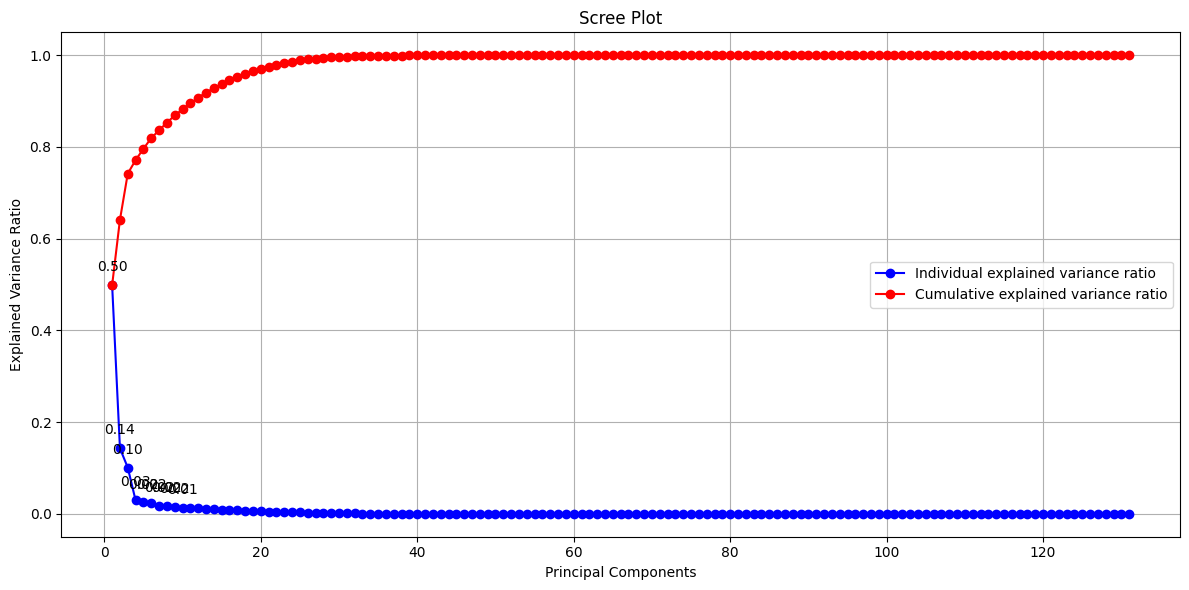

In [ ]:
# Create scree plot and get PCA object
pca = scree_plot(tr.drop('target', axis=1))

In [ ]:
EXPLAINED_VAR_RATIO = 0.97 # Tuning parameter

In [ ]:
# Remove highly correlated features
tr_cleaned = remove_highly_correlated(tr.drop('target', axis=1), EXPLAINED_VAR_RATIO)
tr_cleaned['target'] = tr['target']

Removing 79 highly correlated features: CURE END POSITION Z Collect Result_Dam, CURE END POSITION Θ Collect Result_Dam, CURE START POSITION X Collect Result_Dam, CURE START POSITION Θ Collect Result_Dam, DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam, Dispense Volume(Stage3) Collect Result_Dam, HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam, HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam, HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam, HEAD Standby Position Z Collect Result_Dam, Head Clean Position X Collect Result_Dam, Head Clean Position Y Collect Result_Dam, Head Clean Position Z Collect Result_Dam, Head Purge Position X Collect Result_Dam, Head Purge Position Y Collect Result_Dam, Head Purge Position Z Collect Result_Dam, Head Zero Position X Collect Result_Dam, Head Zero Position Y Collect Result_Dam, Head Zero Position Z Collect Result_Dam, Machine Tact time Collect Result_Dam, Stage1 Circle3 Distance Speed Collect Result_Dam, Stage1 Circle4 Dis

In [ ]:
# prompt: # Sort the remaining column by their importance by PCA

# Fit PCA to the cleaned training data (excluding the target variable)
pca = PCA()
pca.fit(tr_cleaned.drop('target', axis=1))

# Get the feature importances (absolute values of components)
feature_importances = np.abs(pca.components_).sum(axis=0)

# Create a DataFrame to store feature names and importances
feature_importance_df = pd.DataFrame({
    'Feature': tr_cleaned.drop('target', axis=1).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print the sorted feature importances
print(feature_importance_df)


                                              Feature  Importance
32       Dispense Volume(Stage1) Collect Result_Fill1    3.746084
9   HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect ...    3.721871
0              CURE END POSITION X Collect Result_Dam    3.703765
7   HEAD NORMAL COORDINATE X AXIS(Stage2) Collect ...    3.653013
8   HEAD NORMAL COORDINATE X AXIS(Stage3) Collect ...    3.609794
10  HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect ...    3.391504
31  DISCHARGED TIME OF RESIN(Stage3) Collect Resul...    3.383054
33       Dispense Volume(Stage3) Collect Result_Fill1    3.352537
29  DISCHARGED TIME OF RESIN(Stage1) Collect Resul...    3.303702
5          Dispense Volume(Stage1) Collect Result_Dam    3.187699
2        DISCHARGED SPEED OF RESIN Collect Result_Dam    3.143288
30  DISCHARGED TIME OF RESIN(Stage2) Collect Resul...    3.058411
3   DISCHARGED TIME OF RESIN(Stage1) Collect Resul...    3.034679
44  HEAD NORMAL COORDINATE X AXIS(Stage2) Collect ...    3.022726
28     DIS

In [ ]:
# Create compressed datasets
tr_corr_compressed = tr_cleaned
tr_cleaned_exepted_target = tr_cleaned.drop('target', axis=1)
te_corr_compressed = te[tr_cleaned_exepted_target.columns]

print(tr_corr_compressed.shape); print(te_corr_compressed.shape)

(40506, 48)
(17361, 47)


In [ ]:
for col in te_corr_compressed.columns:
  if te_corr_compressed[col].isin(['OK']).any():
    te_corr_compressed[col] = te_corr_compressed[col].map({'OK': 0, 'NG': 1})

In [ ]:
te_corr_compressed['Chamber Temp. Judge Value_AutoClave'].value_counts()

,count
Chamber Temp. Judge Value_AutoClave,
0,12640
1,4721


In [ ]:
# Save compressed datasets
tr_corr_compressed.to_csv(os.path.join(ROOT_DIR,f'tr_pca{EXPLAINED_VAR_RATIO}var.csv'), index=False)
te_corr_compressed.to_csv(os.path.join(ROOT_DIR,f'te_pca{EXPLAINED_VAR_RATIO}var.csv'), index=False)

print(f"Number of features in compressed training set: {tr_corr_compressed.shape[1]}")
print(f"Number of features in compressed test set: {te_corr_compressed.shape[1]}")
print(f"Size of compressed training set: {len(tr_corr_compressed)}")
print(f"Size of compressed test set: {len(te_corr_compressed)}")

Number of features in compressed training set: 48
Number of features in compressed test set: 47
Size of compressed training set: 40506
Size of compressed test set: 17361


## 2.2.1 PCA - (Spherical + Other numeric) - and merge the categorical group 

In [2]:
train = pd.read_csv(os.path.join(ROOT_DIR, 'tr_drop_inv_num.csv')) # Without categorical data
# test = pd.read_csv(os.path.join(ROOT_DIR, 'test_data_combined.csv'))
categorical_data_encoded = pd.read_csv(os.path.join(ROOT_DIR, 'categorical_data_encoded.csv'))
tr_transformed_coordinates = pd.read_csv(os.path.join(ROOT_DIR, 'tr_transformed_coordinates.csv'))

In [3]:
# Drop the target column from the train data
tr_deducted = train.drop('target', axis=1)

In [4]:
Coordinate_columns = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Fill2',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Fill2',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Fill2',
'HEAD Standby Position X Collect Result_Fill2',
'HEAD Standby Position X Unit Time_Fill2',
'HEAD Standby Position X Judge Value_Fill2',
'HEAD Standby Position Y Collect Result_Fill2',
'HEAD Standby Position Y Unit Time_Fill2',
'HEAD Standby Position Y Judge Value_Fill2',
'HEAD Standby Position Z Collect Result_Fill2',
'HEAD Standby Position Z Unit Time_Fill2',
'HEAD Standby Position Z Judge Value_Fill2',
'Head Clean Position X Collect Result_Fill2',
'Head Clean Position X Unit Time_Fill2',
'Head Clean Position X Judge Value_Fill2',
'Head Clean Position Y Collect Result_Fill2',
'Head Clean Position Y Unit Time_Fill2',
'Head Clean Position Y Judge Value_Fill2',
'Head Clean Position Z Collect Result_Fill2',
'Head Clean Position Z Unit Time_Fill2',
'Head Clean Position Z Judge Value_Fill2',
'Head Purge Position X Collect Result_Fill2',
'Head Purge Position X Unit Time_Fill2',
'Head Purge Position X Judge Value_Fill2',
'Head Purge Position Y Collect Result_Fill2',
'Head Purge Position Y Unit Time_Fill2',
'Head Purge Position Y Judge Value_Fill2',
'Head Purge Position Z Collect Result_Fill2',
'Head Purge Position Z Unit Time_Fill2',
'Head Purge Position Z Judge Value_Fill2',
'CURE END POSITION X Collect Result_Fill2',
'CURE END POSITION X Unit Time_Fill2',
'CURE END POSITION X Judge Value_Fill2',
'CURE END POSITION Z Collect Result_Fill2',
'CURE END POSITION Z Unit Time_Fill2',
'CURE END POSITION Z Judge Value_Fill2',
'CURE END POSITION Θ Collect Result_Fill2',
'CURE END POSITION Θ Unit Time_Fill2',
'CURE END POSITION Θ Judge Value_Fill2',
'CURE STANDBY POSITION X Collect Result_Fill2',
'CURE STANDBY POSITION X Unit Time_Fill2',
'CURE STANDBY POSITION X Judge Value_Fill2',
'CURE STANDBY POSITION Z Collect Result_Fill2',
'CURE STANDBY POSITION Z Unit Time_Fill2',
'CURE STANDBY POSITION Z Judge Value_Fill2',
'CURE STANDBY POSITION Θ Collect Result_Fill2',
'CURE STANDBY POSITION Θ Unit Time_Fill2',
'CURE STANDBY POSITION Θ Judge Value_Fill2',
'CURE START POSITION X Collect Result_Fill2',
'CURE START POSITION X Unit Time_Fill2',
'CURE START POSITION X Judge Value_Fill2',
'CURE START POSITION Z Collect Result_Fill2',
'CURE START POSITION Z Unit Time_Fill2',
'CURE START POSITION Z Judge Value_Fill2',
'CURE START POSITION Θ Collect Result_Fill2',
'CURE START POSITION Θ Unit Time_Fill2',
'CURE START POSITION Θ Judge Value_Fill2',
'CURE END POSITION X Collect Result_Dam',
'CURE END POSITION X Unit Time_Dam',
'CURE END POSITION X Judge Value_Dam',
'CURE END POSITION Z Collect Result_Dam',
'CURE END POSITION Z Unit Time_Dam',
'CURE END POSITION Z Judge Value_Dam',
'CURE END POSITION Θ Collect Result_Dam',
'CURE END POSITION Θ Unit Time_Dam',
'CURE END POSITION Θ Judge Value_Dam',
'CURE STANDBY POSITION X Collect Result_Dam',
'CURE STANDBY POSITION X Unit Time_Dam',
'CURE STANDBY POSITION X Judge Value_Dam',
'CURE STANDBY POSITION Z Collect Result_Dam',
'CURE STANDBY POSITION Z Unit Time_Dam',
'CURE STANDBY POSITION Z Judge Value_Dam',
'CURE STANDBY POSITION Θ Collect Result_Dam',
'CURE STANDBY POSITION Θ Unit Time_Dam',
'CURE STANDBY POSITION Θ Judge Value_Dam',
'CURE START POSITION X Collect Result_Dam',
'CURE START POSITION X Unit Time_Dam',
'CURE START POSITION X Judge Value_Dam',
'CURE START POSITION Z Collect Result_Dam',
'CURE START POSITION Z Unit Time_Dam',
'CURE START POSITION Z Judge Value_Dam',
'CURE START POSITION Θ Collect Result_Dam',
'CURE START POSITION Θ Unit Time_Dam',
'CURE START POSITION Θ Judge Value_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Dam',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Dam',
'HEAD Standby Position X Collect Result_Dam',
'HEAD Standby Position X Unit Time_Dam',
'HEAD Standby Position X Judge Value_Dam',
'HEAD Standby Position Y Collect Result_Dam',
'HEAD Standby Position Y Unit Time_Dam',
'HEAD Standby Position Y Judge Value_Dam',
'HEAD Standby Position Z Collect Result_Dam',
'HEAD Standby Position Z Unit Time_Dam',
'HEAD Standby Position Z Judge Value_Dam',
'Head Clean Position X Collect Result_Dam',
'Head Clean Position X Unit Time_Dam',
'Head Clean Position X Judge Value_Dam',
'Head Clean Position Y Collect Result_Dam',
'Head Clean Position Y Unit Time_Dam',
'Head Clean Position Y Judge Value_Dam',
'Head Clean Position Z Collect Result_Dam',
'Head Clean Position Z Unit Time_Dam',
'Head Clean Position Z Judge Value_Dam',
'Head Purge Position X Collect Result_Dam',
'Head Purge Position X Unit Time_Dam',
'Head Purge Position X Judge Value_Dam',
'Head Purge Position Y Collect Result_Dam',
'Head Purge Position Y Unit Time_Dam',
'Head Purge Position Y Judge Value_Dam',
'Head Purge Position Z Collect Result_Dam',
'Head Purge Position Z Unit Time_Dam',
'Head Purge Position Z Judge Value_Dam',
'Head Zero Position X Collect Result_Dam',
'Head Zero Position X Unit Time_Dam',
'Head Zero Position X Judge Value_Dam',
'Head Zero Position Y Collect Result_Dam',
'Head Zero Position Y Unit Time_Dam',
'Head Zero Position Y Judge Value_Dam',
'Head Zero Position Z Collect Result_Dam',
'Head Zero Position Z Unit Time_Dam',
'Head Zero Position Z Judge Value_Dam',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Fill1',
'HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Fill1',
'HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Fill1',
'HEAD Standby Position X Collect Result_Fill1',
'HEAD Standby Position X Unit Time_Fill1',
'HEAD Standby Position X Judge Value_Fill1',
'HEAD Standby Position Y Collect Result_Fill1',
'HEAD Standby Position Y Unit Time_Fill1',
'HEAD Standby Position Y Judge Value_Fill1',
'HEAD Standby Position Z Collect Result_Fill1',
'HEAD Standby Position Z Unit Time_Fill1',
'HEAD Standby Position Z Judge Value_Fill1',
'Head Clean Position X Collect Result_Fill1',
'Head Clean Position X Unit Time_Fill1',
'Head Clean Position X Judge Value_Fill1',
'Head Clean Position Y Collect Result_Fill1',
'Head Clean Position Y Unit Time_Fill1',
'Head Clean Position Y Judge Value_Fill1',
'Head Clean Position Z Collect Result_Fill1',
'Head Clean Position Z Unit Time_Fill1',
'Head Clean Position Z Judge Value_Fill1',
'Head Purge Position X Collect Result_Fill1',
'Head Purge Position X Unit Time_Fill1',
'Head Purge Position X Judge Value_Fill1',
'Head Purge Position Y Collect Result_Fill1',
'Head Purge Position Y Unit Time_Fill1',
'Head Purge Position Y Judge Value_Fill1',
'Head Purge Position Z Collect Result_Fill1',
'Head Purge Position Z Unit Time_Fill1',
'Head Purge Position Z Judge Value_Fill1']


In [5]:
# Drop the duplicated columns from tr_deducted
duplicated_columns = tr_deducted.columns.intersection(Coordinate_columns)
print("Duplicated columns between tr_deducted and categorical_data_encoded:")
print(duplicated_columns)

Duplicated columns between tr_deducted and categorical_data_encoded:
Index(['CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION Θ Collect Result_Dam',
       'CURE START POSITION X Collect Result_Dam',
       'CURE START POSITION Θ Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
       'HEAD Standby Position X Collect Result_Dam',
       'HEAD Standby Position Y Collect Result_Dam',
       'HEAD Standby Position Z Collect 

In [6]:
tr_deducted = tr_deducted.drop(columns=duplicated_columns)
tr_deducted.head()

,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,...,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,WorkMode Collect Result_Fill1,CURE SPEED Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,100,16,14.9,8.4,14.7,1.04,0.58,1.02,265.00,58.5,...,55.7,7,127,1,48,114.612,19.9,7,127,1
1,70,10,21.3,4.9,21.3,1.49,0.34,1.49,65.10,7.0,...,7.0,185,1,7,50,19.600,7.0,185,1,0
2,85,16,14.7,8.5,14.7,1.61,0.93,1.61,265.02,76.9,...,58.7,10,73,1,50,114.612,19.8,10,73,1
3,70,10,21.3,8.4,21.3,1.49,0.58,1.49,70.50,12.0,...,12.0,268,1,7,50,19.900,12.0,268,1,0
4,70,10,9.7,4.9,9.6,0.67,0.34,0.67,88.30,8.0,...,8.0,121,1,7,50,19.700,8.0,121,1,0


In [7]:
duplicated_columns = tr_deducted.columns.intersection(tr_transformed_coordinates.columns)
print("Duplicated columns between tr_deducted and tr_transformed_coordinates:")
print(duplicated_columns)

Duplicated columns between tr_deducted and tr_transformed_coordinates:
Index([], dtype='object')


In [8]:
categorical_columns = ['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'Model.Suffix_AutoClave', 'Workorder_AutoClave', 'Equipment_Fill1',
       'Model.Suffix_Fill1', 'Workorder_Fill1', 'Equipment_Fill2',
       'Model.Suffix_Fill2', 'Workorder_Fill2']

duplicated_columns = tr_deducted.columns.intersection(categorical_columns)
print("Duplicated columns between tr_deducted and categorical columns:")
print(duplicated_columns)

Duplicated columns between tr_deducted and categorical columns:
Index([], dtype='object')


In [9]:
# Check the duplicated column names between tr_deducted and categorical_data_encoded
duplicated_columns = tr_deducted.columns.intersection(categorical_data_encoded.columns)
print("Duplicated columns between tr_deducted and categorical_data_encoded:")
print(duplicated_columns)

Duplicated columns between tr_deducted and categorical_data_encoded:
Index(['PalletID Collect Result_Dam', 'PalletID Collect Result_Fill1',
       'PalletID Collect Result_Fill2'],
      dtype='object')


In [10]:
# Drop the duplicated columns from tr_deducted
tr_deducted = tr_deducted.drop(columns=duplicated_columns)

In [11]:
tr_deducted.head()

,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,Machine Tact time Collect Result_Dam,Production Qty Collect Result_Dam,...,Dispense Volume(Stage3) Collect Result_Fill1,Machine Tact time Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,WorkMode Collect Result_Fill1,CURE SPEED Collect Result_Fill2,Machine Tact time Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,100,16,14.9,8.4,14.7,1.04,0.58,1.02,265.00,7,...,11.97,128.0,7,127,1,48,114.612,7,127,1
1,70,10,21.3,4.9,21.3,1.49,0.34,1.49,65.10,185,...,12.82,56.5,185,1,7,50,19.600,185,1,0
2,85,16,14.7,8.5,14.7,1.61,0.93,1.61,265.02,10,...,12.73,128.0,10,73,1,50,114.612,10,73,1
3,70,10,21.3,8.4,21.3,1.49,0.58,1.49,70.50,268,...,12.82,57.7,268,1,7,50,19.900,268,1,0
4,70,10,9.7,4.9,9.6,0.67,0.34,0.67,88.30,121,...,12.82,89.9,121,1,7,50,19.700,121,1,0


In [12]:
from sklearn.preprocessing import StandardScaler

# Normalize the 3 data - tr_deducted, categorical_data_encoded, tr_transformed_coordinates
scaler = StandardScaler()
tr_deducted_scaled = scaler.fit_transform(tr_deducted)
categorical_data_encoded_scaled = scaler.fit_transform(categorical_data_encoded)
tr_transformed_coordinates_scaled = scaler.fit_transform(tr_transformed_coordinates)

# Create a DataFrame for each of the scaled data
tr_deducted_scaled_df = pd.DataFrame(tr_deducted_scaled, columns=tr_deducted.columns)
categorical_data_encoded_scaled_df = pd.DataFrame(categorical_data_encoded_scaled, columns=categorical_data_encoded.columns)
tr_transformed_coordinates_scaled_df = pd.DataFrame(tr_transformed_coordinates_scaled, columns=tr_transformed_coordinates.columns)

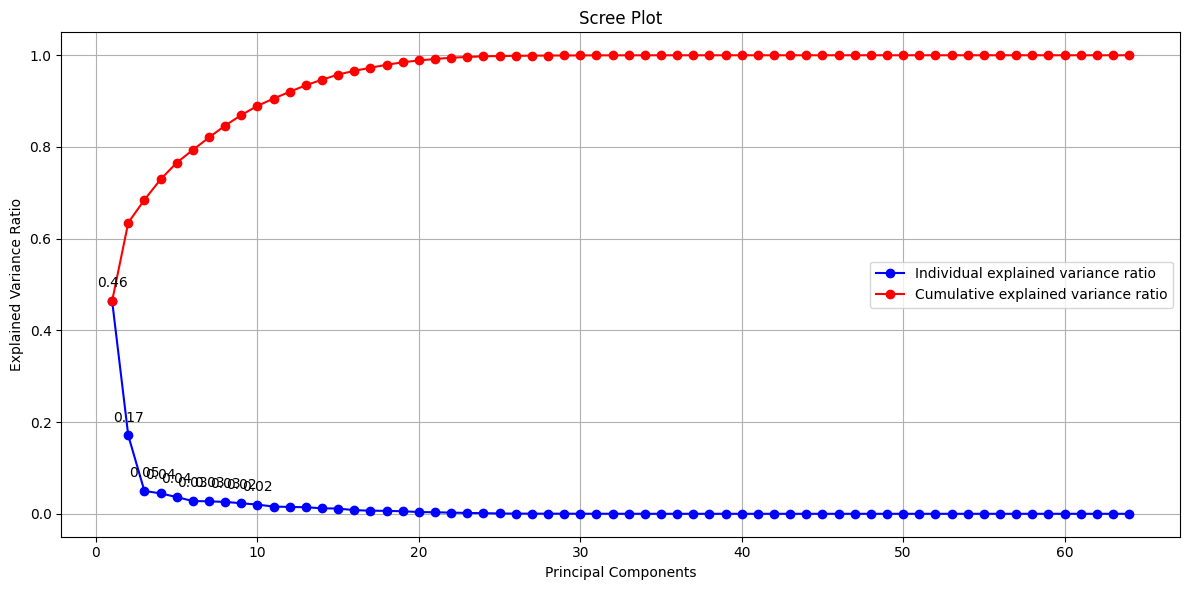

In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Draw scree-plot for tr_deducted_scaled_df
pca = PCA()
pca.fit(tr_deducted_scaled_df)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

for i in range(min(10, len(pca.explained_variance_ratio_))):
    plt.annotate(f'{pca.explained_variance_ratio_[i]:.2f}',
                 (i+1, pca.explained_variance_ratio_[i]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.legend(['Individual explained variance ratio', 'Cumulative explained variance ratio'])
plt.tight_layout()
plt.show()

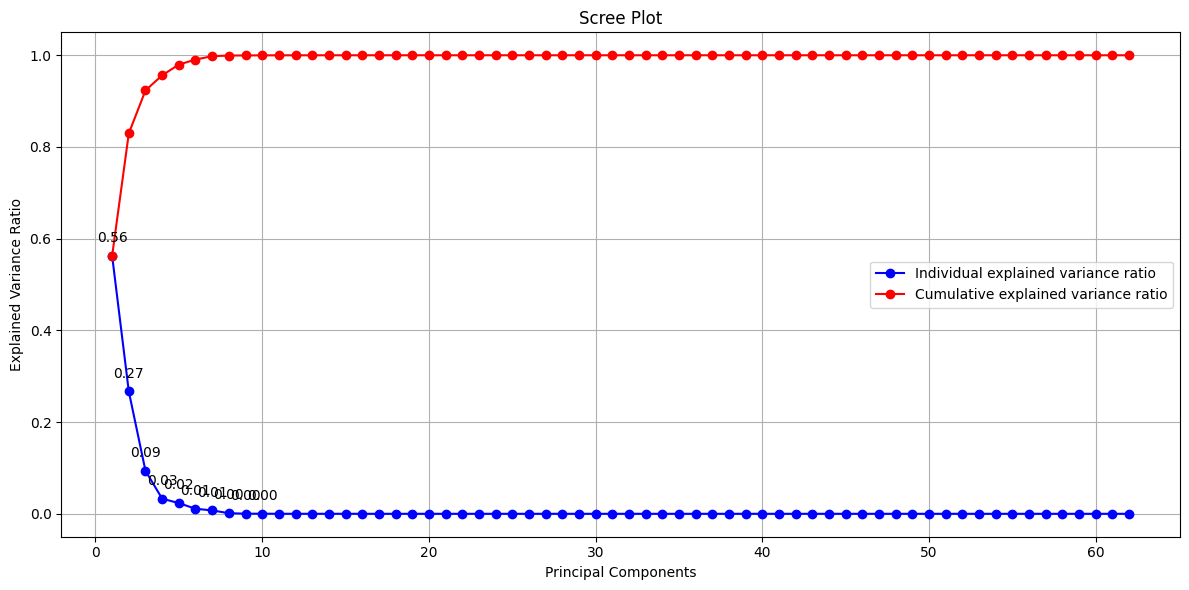

In [17]:
# Draw scree-plot for tr_transformed_coordinates_scaled_df
pca = PCA()
pca.fit(tr_transformed_coordinates_scaled_df)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

for i in range(min(10, len(pca.explained_variance_ratio_))):
    plt.annotate(f'{pca.explained_variance_ratio_[i]:.2f}',
                 (i+1, pca.explained_variance_ratio_[i]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.legend(['Individual explained variance ratio', 'Cumulative explained variance ratio'])
plt.tight_layout()
plt.show()

In [18]:
# Decide on the number of components based on the scree plot
n_components = 19  # Example: choose based on the plots

# Re-fit PCA with the chosen number of components
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(tr_deducted_scaled_df)

# Create DataFrame for the transformed train data
train_deducted_pca_df = pd.DataFrame(train_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Normalize the test features using the same scaler
# test_features = pd.concat([spherical_coords_test, partial_coords_test], axis=1)
# test_features_normalized = scaler.transform(test_features)

# Transform the test data using the same PCA model fitted on training data
# test_pca = pca.transform(test_features_normalized)

# Create DataFrame for the transformed test data
# test_pca_df = pd.DataFrame(test_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Output the transformed data
print("PCA-transformed Training Data:")
print(train_deducted_pca_df.head())

# print("\nPCA-transformed Test Data:")
# print(test_pca_df.head())

PCA-transformed Training Data:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.891998  2.447112  1.139259 -0.831001  0.728743 -0.529436 -0.651090   
1 -0.894747 -7.912827  1.258137 -0.065894  0.057039  1.798276 -0.319993   
2 -4.351461  1.145805 -1.380191  0.771932  0.187663 -0.755023 -1.106070   
3 -3.561014 -7.279059  0.654148 -0.324098  0.725200 -1.262726 -1.647526   
4  7.612667  0.599745 -1.646162 -0.847334  0.600083 -1.467418  1.682767   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -1.555858  1.667934  1.479667  0.178460 -1.033333 -0.185283  1.087786   
1 -0.717733  0.528323  0.909624 -0.051447 -0.291521  0.965834 -0.046423   
2 -1.814241  0.423044  1.185618  1.231808 -0.812331  0.675655 -0.106808   
3  0.820905  1.341720 -1.274717  0.581771  0.858120 -1.078753 -0.273641   
4  1.405032 -0.160710 -0.621083 -0.772511  1.225513 -0.139630 -0.002363   

       PC15      PC16      PC17      PC18      PC19  
0  0.277932  

In [22]:
train_deducted_pca_df.to_csv(os.path.join(ROOT_DIR, 'train_deducted_pca_df.csv'), index=False)

In [20]:
# Decide on the number of components based on the scree plot
n_components = 5  # Example: choose based on the plots

# Re-fit PCA with the chosen number of components
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(tr_transformed_coordinates_scaled_df)

# Create DataFrame for the transformed train data
train_transformed_coordinates_pca_df = pd.DataFrame(train_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Normalize the test features using the same scaler
# test_features = pd.concat([spherical_coords_test, partial_coords_test], axis=1)
# test_features_normalized = scaler.transform(test_features)

# Transform the test data using the same PCA model fitted on training data
# test_pca = pca.transform(test_features_normalized)

# Create DataFrame for the transformed test data
# test_pca_df = pd.DataFrame(test_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Output the transformed data
print("PCA-transformed Training Data:")
print(train_transformed_coordinates_pca_df.head())

# print("\nPCA-transformed Test Data:")
# print(test_pca_df.head())

PCA-transformed Training Data:
        PC1       PC2       PC3       PC4       PC5
0 -3.023347 -5.174471 -0.246752 -0.593305  0.917259
1  7.919741  0.018265 -0.035018 -1.114498  0.228126
2 -6.576635  3.169059 -0.161164  0.380409 -0.434126
3  3.066054  7.921283 -0.059021 -1.560079  2.255790
4  7.664744 -0.392418  0.207350 -0.076481 -1.667725


In [23]:
train_transformed_coordinates_pca_df.to_csv(os.path.join(ROOT_DIR, 'train_transformed_coordinates_pca_df.csv'), index=False)

## 2.2.2 Hellinger distance(Feature selection)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def hellinger_distance(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)

def calculate_hellinger_distances(X, y, n_bins=20):
    n_features = X.shape[1]
    classes = np.unique(y)
    hellinger_distances = []

    for feature in range(n_features):
        feature_data = X[:, feature]

        # Calculate the range for histogram bins
        feature_min, feature_max = np.min(feature_data), np.max(feature_data)
        bin_edges = np.linspace(feature_min, feature_max, n_bins + 1)

        # Calculate histograms for each class using the same bin edges
        hist_data = [np.histogram(feature_data[y == c], bins=bin_edges, density=True)[0] for c in classes]

        # Calculate pairwise Hellinger distances between class distributions
        distances = []
        for i in range(len(classes)):
            for j in range(i + 1, len(classes)):
                dist = hellinger_distance(hist_data[i], hist_data[j])
                distances.append(dist)

        # Use the average Hellinger distance for this feature
        hellinger_distances.append(np.mean(distances))

    return np.array(hellinger_distances)

def select_features_hellinger(X, y, n_features, n_bins=20):
    hellinger_distances = calculate_hellinger_distances(X, y, n_bins)
    selected_features = np.argsort(hellinger_distances)[::-1][:n_features]
    return selected_features

# Main pipeline
def hellinger_feature_selection_pipeline(X, y, n_features_to_select, test_size=0.2, random_state=42, n_bins=20):
    # Ensure X and y have the same number of samples
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"X has {X.shape[0]} samples, but y has {y.shape[0]} samples. They must be equal.")

    # Convert X to DataFrame if it's not already
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Normalize features to [0, 1] range
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Select top features using Hellinger distance
    selected_features = select_features_hellinger(X_train_scaled.values, y_train, n_features_to_select, n_bins)
    selected_columns = X_train.columns[selected_features]

    # Use selected features
    X_train_selected = X_train_scaled[selected_columns]
    X_test_selected = X_test_scaled[selected_columns]

    print(f"Top {n_features_to_select} features selected based on Hellinger distance:")
    print(selected_columns.tolist())

    print(f"\nShape of original dataset: {X.shape}")
    print(f"Shape of training dataset with selected features: {X_train_selected.shape}")
    print(f"Shape of test dataset with selected features: {X_test_selected.shape}")

    return selected_columns, X_train_selected, X_test_selected, y_train, y_test

In [ ]:
X = pd.read_csv(os.path.join(ROOT_DIR, "tr_drop_inv_num.csv"))
y = X.pop('target') # Remove target column from X and assign it to y

In [ ]:
print(X.shape, y.shape);

(40506, 131) (40506,)


In [ ]:
N_FEATURES_TO_SELECT = 60; N_BINS = 20  # You can adjust this value if needed. Default of N_BINS is 20

In [ ]:
hellinger_columns, _, _, _, _ = hellinger_feature_selection_pipeline(X, y, N_FEATURES_TO_SELECT, n_bins=N_BINS, random_state=RANDOM_STATE)
hellinger_columns

Top 60 features selected based on Hellinger distance:
['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2', 'Head Zero Position Z Collect Result_Dam', 'Chamber Temp. Unit Time_AutoClave', 'Stage3 Circle1 Distance Speed Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Dam', 'Stage1 Line4 Distance Speed Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam', 'Dispense Volume(Stage1) Collect Result_Dam', '3rd Pressure Unit Time_AutoClave', 'Dispense Volume(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam', 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage1 Circle1 Distance Speed Collect Result_Dam',

Index(['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2',
       'Head Zero Position Z Collect Result_Dam',
       'Chamber Temp. Unit Time_AutoClave',
       'Stage3 Circle1 Distance Speed Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'Machine Tact time Collect Result_Fill1',
       'Dispense Volume(Stage3) Collect Result_Dam',
       'Stage1 Line4 Distance Speed Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage1) Collect Result_Dam',
       '3rd Pressure Unit Time_AutoClave',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
       'Stage3 Line1 Distance Speed Collect Result_Dam',
       'Stage3 Line3 Distance Speed Collect Result_Dam',
       'Stage1 Line3 Distance Speed Collect Result_Dam',
       'Stage1 Line1 Distance Speed C

In [ ]:
# Modify the test dataset to include only the selected features
te = pd.read_csv(os.path.join(ROOT_DIR, "te_drop_inv_num.csv"))
te_hell = te[hellinger_columns]

tr = pd.read_csv(os.path.join(ROOT_DIR, "tr_drop_inv_num.csv"))
tr_hell = tr[hellinger_columns]

# Add target column from original training data to the selected features if there is not already
if 'target' not in tr_hell.columns:
    tr_hell['target'] = tr['target']

C:\Users\user\AppData\Local\Temp\ipykernel_12380\1909976191.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_hell['target'] = tr['target']


In [ ]:
tr_hell['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [ ]:
# Save the train and test datasets with selected features
tr_hell.to_csv(os.path.join(ROOT_DIR, f"tr_hell{N_FEATURES_TO_SELECT}cols{N_BINS}bins.csv"), index=False)
te_hell.to_csv(os.path.join(ROOT_DIR, f"te_hell{N_FEATURES_TO_SELECT}cols{N_BINS}bins.csv"), index=False)

## 2.3 Hybrid Sampling

In [1]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 6.3 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 10.1 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.0 MB 12.3 MB/s eta 0:00:01
   ------------------------------------ --- 10.0/11.0 MB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 13.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   --- ---------------

In [11]:
!pip uninstall ctgan -y
!pip install ctgan

Found existing installation: ctgan 0.10.1
Uninstalling ctgan-0.10.1:
  Successfully uninstalled ctgan-0.10.1
  Using cached ctgan-0.10.1-py3-none-any.whl.metadata (11 kB)
Using cached ctgan-0.10.1-py3-none-any.whl (24 kB)


In [3]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ipywidgets

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------- ----------------- 1.3/2.3 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour, OneSidedSelection
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.utils import resample
from ctgan import CTGAN
import ipywidgets
import imblearn
import os

OSError: [WinError 126] 지정된 모듈을 찾을 수 없습니다. Error loading "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [ ]:
UNDERSAMPLING_METHOD = 'RUS'  # RUS, TL, OSS
# WARNING: Don't use CNN (extremely slow)
OVERSAMPLING_METHOD = 'CTGAN'  # CTGAN, SMOTE, BorderlineSMOTE, ADASYN
RANDOM_STATE = 110

In [ ]:
def hybrid_sampling(train_data, undersampling_rate, undersampling_method='TL', oversampling_method='SMOTE'):
    # Separate features and target
    X = train_data.drop('target', axis=1)
    y = train_data['target']

    # Undersampling
    if undersampling_method.upper() == 'RUS':
        n_normal = len(train_data[train_data['target'] == 1])
        n_keep = max(int(n_normal * undersampling_rate), len(train_data[train_data['target'] == -1]))
        rus = RandomUnderSampler(sampling_strategy={1: n_keep}, random_state=RANDOM_STATE)
        X_under, y_under = rus.fit_resample(X, y)
    elif undersampling_method.upper() == 'TL':
        tl = TomekLinks(sampling_strategy='majority')
        X_under, y_under = tl.fit_resample(X, y)
    elif undersampling_method.upper() == 'CNN':
        # Use CNN with a limit on the number of iterations
        cnn = CondensedNearestNeighbour(sampling_strategy='majority', random_state=RANDOM_STATE, n_neighbors=1, n_seeds_S=1)
        X_under, y_under = cnn.fit_resample(X, y)
    elif undersampling_method.upper() == 'OSS':
        oss = OneSidedSelection(sampling_strategy='majority', random_state=RANDOM_STATE)
        X_under, y_under = oss.fit_resample(X, y)
    else:
        raise ValueError("Invalid undersampling method. Choose 'RUS', 'TL', 'CNN', or 'OSS'.")

    # Combine undersampled data
    undersampled_data = pd.concat([X_under, pd.Series(y_under, name='target')], axis=1)

    # Separate normal and abnormal samples after undersampling
    normal_samples = undersampled_data[undersampled_data['target'] == 1]
    abnormal_samples = undersampled_data[undersampled_data['target'] == -1]

    # If TL, CNN, or OSS was used, we might need additional random undersampling
    if undersampling_method.upper() in ['TL', 'CNN', 'OSS']:
        n_normal_desired = max(int(len(normal_samples) * undersampling_rate), len(abnormal_samples))
        if len(normal_samples) > n_normal_desired:
            normal_samples = resample(normal_samples, n_samples=n_normal_desired, random_state=RANDOM_STATE)

    # Determine the number of synthetic samples to generate
    n_synthetic = max(0, len(normal_samples) - len(abnormal_samples))

    if n_synthetic > 0:
        if oversampling_method.upper() == 'SMOTE':
            smote = SMOTE(sampling_strategy={-1: len(normal_samples)}, random_state=RANDOM_STATE)
            X_resampled, y_resampled = smote.fit_resample(
                pd.concat([normal_samples, abnormal_samples]).drop('target', axis=1),
                pd.concat([normal_samples, abnormal_samples])['target']
            )
            final_data = pd.concat([X_resampled, pd.Series(y_resampled, name='target')], axis=1)
        elif oversampling_method.upper() == 'CTGAN':
            ctgan = CTGAN()  # CTGAN doesn't accept random_state
            ctgan.fit(abnormal_samples, epochs=100)
            synthetic_samples = ctgan.sample(n_synthetic)
            final_data = pd.concat([normal_samples, abnormal_samples, synthetic_samples], axis=0)
        elif oversampling_method.upper() == 'BORDERLINESMOTE':
            bsmote = BorderlineSMOTE(sampling_strategy={-1: len(normal_samples)}, random_state=RANDOM_STATE)
            X_resampled, y_resampled = bsmote.fit_resample(
                pd.concat([normal_samples, abnormal_samples]).drop('target', axis=1),
                pd.concat([normal_samples, abnormal_samples])['target']
            )
            final_data = pd.concat([X_resampled, pd.Series(y_resampled, name='target')], axis=1)
        elif oversampling_method.upper() == 'ADASYN':
            adasyn = ADASYN(sampling_strategy={-1: len(normal_samples)}, random_state=RANDOM_STATE)
            X_resampled, y_resampled = adasyn.fit_resample(
                pd.concat([normal_samples, abnormal_samples]).drop('target', axis=1),
                pd.concat([normal_samples, abnormal_samples])['target']
            )
            final_data = pd.concat([X_resampled, pd.Series(y_resampled, name='target')], axis=1)
        else:
            raise ValueError("Invalid oversampling method. Choose 'SMOTE', 'CTGAN', 'BorderlineSMOTE', or 'ADASYN'.")
    else:
        final_data = pd.concat([normal_samples, abnormal_samples], axis=0)

    print(f"Final data shape: {final_data.shape}")
    print(f"Normal samples: {len(final_data[final_data['target'] == 1])}")
    print(f"Abnormal samples: {len(final_data[final_data['target'] == -1])}")

    return final_data

def save_to_csv(data, filename):
    """
    Save the given DataFrame to a CSV file.
    :param data: pandas DataFrame to save
    :param filename: name of the file to save (without extension)
    """
    if not os.path.exists('sampled_datasets'):
        os.makedirs('sampled_datasets')
    filepath = os.path.join('sampled_datasets', f"{filename}.csv")
    data.to_csv(filepath, index=False)
    print(f"Saved sampled dataset to {filepath}")

In [ ]:
undersampling_rates = [0.10]; results = {}

In [ ]:
DATA_TYPE = 'hell'
N_FEATURES_TO_SELECT = 50; N_BINS = 20 # For hellinger distance
EXPLAINED_VAR_RATIO = 0.95 # Write the value used in the PCA part
# e.g. pca, hell(hellinger), rowwisedrop_pca, rowwisedrop_doublepca80var

# For pca data
# train_data = pd.read_csv(os.path.join(ROOT_DIR, f"tr_strtuned_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var.csv"))

# For Hellinger data
# train_data = pd.read_csv(os.path.join(ROOT_DIR, f"tr_{DATA_TYPE}{N_FEATURES_TO_SELECT}cols{N_BINS}bins.csv"))

# For non-var_select data
train_data = pd.read_csv(os.path.join(ROOT_DIR, f"tr_drop_inv_num_coor_encoded.csv"))

In [ ]:
for rate in undersampling_rates:
    print(f"\nProcessing undersampling rate: {rate}")
    resampled_data = hybrid_sampling(train_data, rate, undersampling_method=UNDERSAMPLING_METHOD, oversampling_method=OVERSAMPLING_METHOD)

    # Store results
    results[rate] = {
        'resampled_data': resampled_data,
        'original_normal_count': len(train_data[train_data['target'] == 1]),
        'original_abnormal_count': len(train_data[train_data['target'] == -1]),
        'resampled_normal_count': len(resampled_data[resampled_data['target'] == 1]),
        'resampled_abnormal_count': len(resampled_data[resampled_data['target'] == -1]),
    }

    print(f"Original data shape: {train_data.shape}")
    print(f"Resampled data shape: {resampled_data.shape}")
    print(f"Original normal samples: {results[rate]['original_normal_count']}")
    print(f"Original abnormal samples: {results[rate]['original_abnormal_count']}")
    print(f"Resampled normal samples: {results[rate]['resampled_normal_count']}")
    print(f"Resampled abnormal samples: {results[rate]['resampled_abnormal_count']}")

    # Save the resampled data to a CSV file

    # For PCA data
#     save_to_csv(resampled_data, f"tr_strtuned_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var_{UNDERSAMPLING_METHOD}{int(rate*100)}perc_{OVERSAMPLING_METHOD}")

    # For Hell data
    # save_to_csv(resampled_data, f"tr_{DATA_TYPE}{N_FEATURES_TO_SELECT}cols{N_BINS}bins_{UNDERSAMPLING_METHOD}{int(rate*100)}perc_{OVERSAMPLING_METHOD}")

    # For non-PCA data
    save_to_csv(resampled_data, f"tr_drop_inv_num_coor_encoded_{UNDERSAMPLING_METHOD}{int(rate*100)}perc_{OVERSAMPLING_METHOD}")

    print("\n")

# The results dictionary now contains the resampled data and statistics for each undersampling rate


Processing undersampling rate: 0.1
Final data shape: (7630, 40)
Normal samples: 3815
Abnormal samples: 3815
Original data shape: (40506, 40)
Resampled data shape: (7630, 40)
Original normal samples: 38156
Original abnormal samples: 2350
Resampled normal samples: 3815
Resampled abnormal samples: 3815
Saved sampled dataset to sampled_datasets/tr_pca0.91var_RUS10perc_CTGAN.csv




## 3. 모델 학습


## 3.1 Deep SVDD

In [ ]:
pip install easydict

Note: you may need to restart the kernel to use updated packages.


## 3.2 XGBoost with hybrid sampling

In [ ]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 11.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 8.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os

In [ ]:
def load_data(filename):
    """
    Load data from a CSV file.

    :param filename: name of the file to load (without extension)
    :return: pandas DataFrame
    """
    filepath = os.path.join('sampled_datasets', f"{filename}.csv")
    return pd.read_csv(filepath)

def train_xgboost_model(X, y):
    """
    Train an XGBoost model.

    :param X: feature DataFrame
    :param y: target Series
    :return: trained XGBoost model, label encoder
    """
    # Create a LabelEncoder object
    le = LabelEncoder()

    # Fit the LabelEncoder and transform the target variable
    y_encoded = le.fit_transform(y)

    # Create and train the XGBoost model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X, y_encoded)

    return model, le

def evaluate_model(model, X, y, le):
    """
    Evaluate the model and return performance metrics.

    :param model: trained model
    :param X: feature DataFrame
    :param y: target Series
    :param le: fitted LabelEncoder
    :return: dictionary of performance metrics
    """
    y_encoded = le.transform(y)
    y_pred = model.predict(X)
    y_pred = le.inverse_transform(y_pred)

    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, average='weighted'),
        'recall': recall_score(y, y_pred, average='weighted'),
        'f1': f1_score(y, y_pred, average='weighted')
    }

def save_model(model, le, filename):
    """
    Save the trained model and label encoder to files.

    :param model: trained model to save
    :param le: fitted LabelEncoder to save
    :param filename: base name of the files to save (without extension)
    """
    if not os.path.exists('trained_XGB_models'):
        os.makedirs('trained_XGB_models')

    model_filepath = os.path.join('trained_XGB_models', f"{filename}_model.joblib")
    le_filepath = os.path.join('trained_XGB_models', f"{filename}_encoder.joblib")

    joblib.dump(model, model_filepath)
    joblib.dump(le, le_filepath)
    print(f"Saved model to {model_filepath} and encoder to {le_filepath}")

def load_model(filename):
    """
    Load a saved model and label encoder from files.

    :param filename: base name of the files to load (without extension)
    :return: loaded model, loaded label encoder
    """
    model_filepath = os.path.join('trained_XGB_models', f"{filename}_model.joblib")
    le_filepath = os.path.join('trained_XGB_models', f"{filename}_encoder.joblib")

    if os.path.exists(model_filepath) and os.path.exists(le_filepath):
        model = joblib.load(model_filepath)
        le = joblib.load(le_filepath)
        print(f"Loaded model from {model_filepath} and encoder from {le_filepath}")
        return model, le
    else:
        print(f"Model or encoder file not found: {model_filepath} or {le_filepath}")
        return None, None

In [ ]:
undersampling_rates = [0.01 ,0.02, 0.03, 0.04]; results = {}

In [ ]:
for rate in undersampling_rates:
    print(f"\nProcessing model for undersampling rate: {rate}")

    # Load the sampled dataset
    data = load_data(f"sampled_data_{int(rate*100)}percent")

    # Split features and target
    X = data.drop('target', axis=1)
    y = data['target']

    # Print unique values in y
    print(f"Unique values in target: {y.unique()}")

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    # Train the model
    model, le = train_xgboost_model(X_train, y_train)

    # Evaluate the model
    train_metrics = evaluate_model(model, X_train, y_train, le)
    val_metrics = evaluate_model(model, X_val, y_val, le)

    # Save the model and encoder
    save_model(model, le, f"xgboost_model_{int(rate*100)}percent")

    # Store results
    results[rate] = {
        'train_metrics': train_metrics,
        'val_metrics': val_metrics
    }

    print(f"Train metrics: {train_metrics}")
    print(f"Validation metrics: {val_metrics}")



Processing model for undersampling rate: 0.01
Unique values in target: [ 1 -1]


/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:08:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model to trained_models/xgboost_model_1percent_model.joblib and encoder to trained_models/xgboost_model_1percent_encoder.joblib
Train metrics: {'accuracy': 0.9125, 'precision': 0.9125110131971629, 'recall': 0.9125, 'f1': 0.9125002785131114}
Validation metrics: {'accuracy': 0.5851063829787234, 'precision': 0.5858493273963433, 'recall': 0.5851063829787234, 'f1': 0.5848809340752722}

Processing model for undersampling rate: 0.02
Unique values in target: [ 1 -1]


/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:08:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model to trained_models/xgboost_model_2percent_model.joblib and encoder to trained_models/xgboost_model_2percent_encoder.joblib
Train metrics: {'accuracy': 0.9356382978723404, 'precision': 0.9356407798672373, 'recall': 0.9356382978723404, 'f1': 0.9356384799744154}
Validation metrics: {'accuracy': 0.6159574468085106, 'precision': 0.6174601613658938, 'recall': 0.6159574468085106, 'f1': 0.6154149419302485}

Processing model for undersampling rate: 0.03
Unique values in target: [ 1 -1]


/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:08:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model to trained_models/xgboost_model_3percent_model.joblib and encoder to trained_models/xgboost_model_3percent_encoder.joblib
Train metrics: {'accuracy': 0.9215425531914894, 'precision': 0.9215425170716709, 'recall': 0.9215425531914894, 'f1': 0.9215424699467779}
Validation metrics: {'accuracy': 0.6, 'precision': 0.6011403161785767, 'recall': 0.6, 'f1': 0.5995868741959447}

Processing model for undersampling rate: 0.04
Unique values in target: [ 1 -1]
Saved model to trained_models/xgboost_model_4percent_model.joblib and encoder to trained_models/xgboost_model_4percent_encoder.joblib
Train metrics: {'accuracy': 0.9287234042553192, 'precision': 0.928885729897552, 'recall': 0.9287234042553192, 'f1': 0.9287194111449967}
Validation metrics: {'accuracy': 0.5904255319148937, 'precision': 0.5910066989020623, 'recall': 0.5904255319148937, 'f1': 0.5902980439058709}


/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:08:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Demonstrate loading and using a saved model
print("\nDemonstrating model loading and usage:")
loaded_model, loaded_le = load_model("xgboost_model_9percent")

if loaded_model is not None and loaded_le is not None:
    # Load the corresponding dataset
    test_data = load_data("sampled_data_10percent")
    X_test = test_data.drop('target', axis=1)
    y_test = test_data['target']

    # Evaluate the loaded model
    test_metrics = evaluate_model(loaded_model, X_test, y_test, loaded_le)
    print("Test metrics for loaded model:")
    print(test_metrics)


Demonstrating model loading and usage:
Loaded model from trained_models/xgboost_model_9percent_model.joblib and encoder from trained_models/xgboost_model_9percent_encoder.joblib
Test metrics for loaded model:
{'accuracy': 0.7935779816513762, 'precision': 0.7951565805383443, 'recall': 0.7935779816513762, 'f1': 0.793301608132323}


In [ ]:
# Load the saved model (change the filename as needed)
model, le = load_model("xgboost_model_9percent")

Loaded model from trained_models/xgboost_model_9percent_model.joblib and encoder from trained_models/xgboost_model_9percent_encoder.joblib


## 3.3 RF with hybrid sampling

In [ ]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

RANDOM_STATE = 110
ROOT_DIR = "data"

train_data = pd.read_csv(os.path.join(ROOT_DIR, "tr_drop_inv_num_compressed_fa.csv"))

model = RandomForestClassifier(random_state=RANDOM_STATE)

train_x = train_data.iloc[:, :-1].to_numpy()
train_y = train_data.iloc[:, [-1]].to_numpy() # x,y 값 분리
train_y = train_y.reshape(-1) # Convert train_y into 1-dim array

model.fit(train_x, train_y)

RandomForestClassifier(random_state=110)

In [ ]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "te_drop_inv_num_compressed_fa.csv"))

predictions = model.predict(test_data)
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

/home/elicer/.local/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


{-1: 73, 1: 17288}

## 3.4 LightGBM with hybrid sampling

In [ ]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os

def load_data(filename):
    """
    Load data from a CSV file.

    :param filename: name of the file to load (without extension)
    :return: pandas DataFrame
    """
    filepath = os.path.join('sampled_datasets', f"{filename}.csv")
    return pd.read_csv(filepath)

def train_lightgbm_model(X, y):
    """
    Train a LightGBM model.

    :param X: feature DataFrame
    :param y: target Series
    :return: trained LightGBM model, label encoder
    """
    # Create a LabelEncoder object
    le = LabelEncoder()

    # Fit the LabelEncoder and transform the target variable
    y_encoded = le.fit_transform(y)

    # Create and train the LightGBM model
    model = LGBMClassifier(random_state=RANDOM_STATE)
    model.fit(X, y_encoded)

    return model, le

def evaluate_model(model, X, y, le):
    """
    Evaluate the model and return performance metrics.

    :param model: trained model
    :param X: feature DataFrame
    :param y: target Series
    :param le: fitted LabelEncoder
    :return: dictionary of performance metrics
    """
    y_encoded = le.transform(y)
    y_pred = model.predict(X)
    y_pred = le.inverse_transform(y_pred)

    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, average='weighted'),
        'recall': recall_score(y, y_pred, average='weighted'),
        'f1': f1_score(y, y_pred, average='weighted')
    }

def save_model(model, le, filename):
    """
    Save the trained model and label encoder to files.

    :param model: trained model to save
    :param le: fitted LabelEncoder to save
    :param filename: base name of the files to save (without extension)
    """
    if not os.path.exists('trained_LGBM_models'):
        os.makedirs('trained_LGBM_models')

    model_filepath = os.path.join('trained_LGBM_models', f"{filename}_model.joblib")
    le_filepath = os.path.join('trained_LGBM_models', f"{filename}_encoder.joblib")

    joblib.dump(model, model_filepath)
    joblib.dump(le, le_filepath)
    print(f"Saved model to {model_filepath} and encoder to {le_filepath}")

def load_model(filename):
    """
    Load a saved model and label encoder from files.

    :param filename: base name of the files to load (without extension)
    :return: loaded model, loaded label encoder
    """
    model_filepath = os.path.join('trained_LGBM_models', f"{filename}_model.joblib")
    le_filepath = os.path.join('trained_LGBM_models', f"{filename}_encoder.joblib")

    if os.path.exists(model_filepath) and os.path.exists(le_filepath):
        model = joblib.load(model_filepath)
        le = joblib.load(le_filepath)
        print(f"Loaded model from {model_filepath} and encoder from {le_filepath}")
        return model, le
    else:
        print(f"Model or encoder file not found: {model_filepath} or {le_filepath}")
        return None, None

In [ ]:
# Undersampling rates used in the previous step
DATA_TYPE = 'pca'
# e.g. pca, doublepca80var, rowwisedrop_pca, rowwisedrop_doublepca80var

undersampling_rates = [.1]; results = {}

In [ ]:
for rate in undersampling_rates:
    print(f"\nProcessing model for undersampling rate: {rate}")

    # Load the sampled dataset
    data = load_data(f"tr_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var_{UNDERSAMPLING_METHOD}{int(rate*100)}perc_{OVERSAMPLING_METHOD}")

    # Split features and target
    X = data.drop('target', axis=1)
    y = data['target']

    # Print unique values in y
    print(f"Unique values in target: {y.unique()}")

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    # Train the model
    model, le = train_lightgbm_model(X_train, y_train)

    # Evaluate the model
    train_metrics = evaluate_model(model, X_train, y_train, le)
    val_metrics = evaluate_model(model, X_val, y_val, le)

    # Save the model and encoder
    save_model(model, le, f"lightgbm_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var_{UNDERSAMPLING_METHOD}{int(rate*100)}perc_{OVERSAMPLING_METHOD}")

    # Store results
    results[rate] = {
        'train_metrics': train_metrics,
        'val_metrics': val_metrics
    }

    print(f"Train metrics: {train_metrics}")
    print(f"Validation metrics: {val_metrics}")


Processing model for undersampling rate: 0.1
Unique values in target: [ 1 -1]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3059, number of negative: 3045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7076
[LightGBM] [Info] Number of data points in the train set: 6104, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501147 -> initscore=0.004587
[LightGBM] [Info] Start training from score 0.004587
Saved model to trained_LGBM_models/lightgbm_pca0.91var_RUS10perc_CTGAN_model.joblib and encoder to trained_LGBM_models/lightgbm_pca0.91var_RUS10perc_CTGAN_encoder.joblib
Train metrics: {'accuracy': 0.846002621231979, 'precision': 0.8631311705726645, 'recall': 0.846002621231979, 'f1': 0.8

In [ ]:
# Print overall results
print("\nOverall Results:")
for rate, metrics in results.items():
    print(f"\nModel with {int(rate*100)}% undersampling:")
    print(f"Train metrics: {metrics['train_metrics']}")
    print(f"Validation metrics: {metrics['val_metrics']}")


Overall Results:

Model with 10% undersampling:
Train metrics: {'accuracy': 0.846002621231979, 'precision': 0.8631311705726645, 'recall': 0.846002621231979, 'f1': 0.8441186532095177}
Validation metrics: {'accuracy': 0.6887287024901704, 'precision': 0.7014742522134526, 'recall': 0.6887287024901704, 'f1': 0.6843480822019262}


In [ ]:
for rate in undersampling_rates:
    print(f"\nProcessing model for undersampling rate: {rate}")

    # Load the sampled dataset
    data = load_data(f"tr_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var_{UNDERSAMPLING_METHOD}{int(rate*100)}perc_{OVERSAMPLING_METHOD}")

    # Split features and target
    X = data.drop('target', axis=1)
    y = data['target']

    # Print unique values in y
#     print(f"Unique values in target: {y.unique()}")

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    # Train the model
    model, le = train_lightgbm_model(X_train, y_train)

    # Evaluate the model
    train_metrics = evaluate_model(model, X_train, y_train, le)
    val_metrics = evaluate_model(model, X_val, y_val, le)

    # Save the model and encoder
    save_model(model, le, f"lightgbm_model_{DATA_TYPE}_{int(rate*100)}percent")

    # Store results
    results[rate] = {
        'train_metrics': train_metrics,
        'val_metrics': val_metrics
    }

    print(f"Train metrics: {train_metrics}")
    print(f"Validation metrics: {val_metrics}")

# Print overall results
print("\nOverall Results:")
for rate, metrics in results.items():
    print(f"\nModel with {int(rate*100)}% undersampling:")
    print(f"Train metrics: {metrics['train_metrics']}")
    print(f"Validation metrics: {metrics['val_metrics']}")


Processing model for undersampling rate: 0.1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3059, number of negative: 3045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7076
[LightGBM] [Info] Number of data points in the train set: 6104, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501147 -> initscore=0.004587
[LightGBM] [Info] Start training from score 0.004587
Saved model to trained_LGBM_models/lightgbm_model_pca_10percent_model.joblib and encoder to trained_LGBM_models/lightgbm_model_pca_10percent_encoder.joblib
Train metrics: {'accuracy': 0.846002621231979, 'precision': 0.8631311705726645, 'recall': 0.846002621231979, 'f1': 0.8441186532095177}
Validation metrics: {'accuracy

### Load a model & Predict

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
import os

def load_model(filename):
    """
    Load a saved model and label encoder from files.

    :param filename: base name of the files to load (without extension)
    :return: loaded model, loaded label encoder
    """
    model_filepath = os.path.join('trained_LGBM_models', f"{filename}_model.joblib")
    le_filepath = os.path.join('trained_LGBM_models', f"{filename}_encoder.joblib")

    if os.path.exists(model_filepath) and os.path.exists(le_filepath):
        model = joblib.load(model_filepath)
        le = joblib.load(le_filepath)
        print(f"Loaded model from {model_filepath} and encoder from {le_filepath}")
        return model, le
    else:
        print(f"Model or encoder file not found: {model_filepath} or {le_filepath}")
        return None, None

def load_data(filename):
    """
    Load data from a CSV file.

    :param filename: name of the file to load (without extension)
    :return: pandas DataFrame
    """
    return pd.read_csv(f"{filename}.csv")

def make_predictions(model, le, X):
    """
    Make predictions using the model.

    :param model: trained LightGBM model
    :param le: fitted LabelEncoder
    :param X: feature DataFrame
    :return: predictions
    """
    # Make predictions
    y_pred = model.predict(X)

    # Inverse transform predictions to original labels
    y_pred = le.inverse_transform(y_pred)

    return y_pred

In [ ]:
DATA_TYPE = 'pca'; UNDERSAMPLING_RATE = 0.10;

In [ ]:
# Load the saved model (change the filename as needed)
model, le = load_model(f"lightgbm_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var_{UNDERSAMPLING_METHOD}{int(rate*100)}perc_{OVERSAMPLING_METHOD}")

if model is not None and le is not None:
    # Load the test data
    test_data = pd.read_csv(os.path.join(ROOT_DIR, f"te_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var.csv"))

    # Make predictions
    predictions = make_predictions(model, le, test_data)

    # Print a sample of predictions
    print("\nSample of Predictions:")
    print(predictions)

Loaded model from trained_LGBM_models/lightgbm_pca0.91var_RUS10perc_CTGAN_model.joblib and encoder from trained_LGBM_models/lightgbm_pca0.91var_RUS10perc_CTGAN_encoder.joblib

Sample of Predictions:
[ 1  1 -1 ...  1  1  1]


## 3.5 Ensemble(Catboost + LightGBM + XGB)

In [ ]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 356.4 kB/s eta 0:00:0000:0100:07
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 529.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import joblib
import os

def load_data(filename):
    """
    Load data from a CSV file in the sampled_datasets folder.

    :param filename: name of the file to load (without extension)
    :return: pandas DataFrame
    """
    filepath = os.path.join('sampled_datasets', f"{filename}.csv")
    return pd.read_csv(filepath)

def create_ensemble_model():
    """
    Create an ensemble model with CatBoost, LightGBM, and XGBoost.

    :return: VotingClassifier ensemble model
    """
    catboost_model = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
    lightgbm_model = LGBMClassifier(random_state=RANDOM_STATE)
    xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)

    ensemble_model = VotingClassifier(
        estimators=[
            ('catboost', catboost_model),
            ('lightgbm', lightgbm_model),
            ('xgboost', xgboost_model)
        ],
        voting='soft'
    )

    return ensemble_model

def train_ensemble_model(X, y):
    """
    Train the ensemble model.

    :param X: feature DataFrame
    :param y: target Series
    :return: trained ensemble model, label encoder
    """
    # Create a LabelEncoder object
    le = LabelEncoder()

    # Fit the LabelEncoder and transform the target variable
    y_encoded = le.fit_transform(y)

    # Create and train the ensemble model
    model = create_ensemble_model()
    model.fit(X, y_encoded)

    return model, le

def evaluate_model(model, X, y, le):
    """
    Evaluate the model and return performance metrics.

    :param model: trained model
    :param X: feature DataFrame
    :param y: target Series
    :param le: fitted LabelEncoder
    :return: dictionary of performance metrics
    """
    y_encoded = le.transform(y)
    y_pred = model.predict(X)
    y_pred = le.inverse_transform(y_pred)

    return {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, average='weighted'),
        'recall': recall_score(y, y_pred, average='weighted'),
        'f1': f1_score(y, y_pred, average='weighted')
    }

def save_model(model, le, filename):
    """
    Save the trained model and label encoder to files.

    :param model: trained model to save
    :param le: fitted LabelEncoder to save
    :param filename: base name of the files to save (without extension)
    """
    if not os.path.exists('trained_EnsembleBoost_models'):
        os.makedirs('trained_EnsembleBoost_models')

    model_filepath = os.path.join('trained_EnsembleBoost_models', f"{filename}_model.joblib")
    le_filepath = os.path.join('trained_EnsembleBoost_models', f"{filename}_encoder.joblib")

    joblib.dump(model, model_filepath)
    joblib.dump(le, le_filepath)
    print(f"Saved model to {model_filepath} and encoder to {le_filepath}")

def load_model(filename):
    """
    Load a saved model and label encoder from files.

    :param filename: base name of the files to load (without extension)
    :return: loaded model, loaded label encoder
    """
    model_filepath = os.path.join('trained_EnsembleBoost_models', f"{filename}_model.joblib")
    le_filepath = os.path.join('trained_EnsembleBoost_models', f"{filename}_encoder.joblib")

    if os.path.exists(model_filepath) and os.path.exists(le_filepath):
        model = joblib.load(model_filepath)
        le = joblib.load(le_filepath)
        print(f"Loaded model from {model_filepath} and encoder from {le_filepath}")
        return model, le
    else:
        print(f"Model or encoder file not found: {model_filepath} or {le_filepath}")
        return None, None

In [ ]:
# Undersampling rates
undersampling_rates = [0.15, 0.2, 0.25, 0.3]; results = {}

In [ ]:
for rate in undersampling_rates:
    print(f"\nProcessing ensemble model for undersampling rate: {rate}")

    # Load the sampled dataset
    data = load_data(f"sampled_data_{int(rate*100)}percent")

    # Split features and target
    X = data.drop('target', axis=1)
    y = data['target']

    # Print unique values in y
    print(f"Unique values in target: {y.unique()}")

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    # Train the ensemble model
    model, le = train_ensemble_model(X_train, y_train)

    # Evaluate the model
    train_metrics = evaluate_model(model, X_train, y_train, le)
    val_metrics = evaluate_model(model, X_val, y_val, le)

    # Save the model and encoder
    save_model(model, le, f"ensemble_model_{int(rate*100)}percent")

    # Store results
    results[rate] = {
        'train_metrics': train_metrics,
        'val_metrics': val_metrics
    }

    print(f"Train metrics: {train_metrics}")
    print(f"Validation metrics: {val_metrics}")


Processing ensemble model for undersampling rate: 0.15
Unique values in target: [ 1 -1]
[LightGBM] [Info] Number of positive: 4553, number of negative: 4603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24024
[LightGBM] [Info] Number of data points in the train set: 9156, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497270 -> initscore=-0.010922
[LightGBM] [Info] Start training from score -0.010922


/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:32:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model to trained_EnsembleBoost_models/ensemble_model_15percent_model.joblib and encoder to trained_EnsembleBoost_models/ensemble_model_15percent_encoder.joblib
Train metrics: {'accuracy': 0.8793141109654871, 'precision': 0.900353325141369, 'recall': 0.8793141109654871, 'f1': 0.8777933287864641}
Validation metrics: {'accuracy': 0.8087336244541484, 'precision': 0.8319101273325848, 'recall': 0.8087336244541484, 'f1': 0.8046112516110973}

Processing ensemble model for undersampling rate: 0.2
Unique values in target: [ 1 -1]
[LightGBM] [Info] Number of positive: 6104, number of negative: 6105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24118
[LightGBM] [Info] Number of data points in the train set: 12209, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499959 -> initscore=-0.000164
[LightGBM] [Info] Start trai

/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:32:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model to trained_EnsembleBoost_models/ensemble_model_20percent_model.joblib and encoder to trained_EnsembleBoost_models/ensemble_model_20percent_encoder.joblib
Train metrics: {'accuracy': 0.8890982062412974, 'precision': 0.9087355567743722, 'recall': 0.8890982062412974, 'f1': 0.8877510884362257}
Validation metrics: {'accuracy': 0.8509662626924337, 'precision': 0.875871153458653, 'recall': 0.8509662626924337, 'f1': 0.8484485060882172}

Processing ensemble model for undersampling rate: 0.25
Unique values in target: [ 1 -1]
[LightGBM] [Info] Number of positive: 7611, number of negative: 7651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24152
[LightGBM] [Info] Number of data points in the train set: 15262, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498690 -> initscore=-0.005242
[LightGBM] [Info] Start tra

/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:33:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model to trained_EnsembleBoost_models/ensemble_model_25percent_model.joblib and encoder to trained_EnsembleBoost_models/ensemble_model_25percent_encoder.joblib
Train metrics: {'accuracy': 0.9021098152273621, 'precision': 0.9178615095596752, 'recall': 0.9021098152273621, 'f1': 0.9012061158401942}
Validation metrics: {'accuracy': 0.8875786163522013, 'precision': 0.9047584660354366, 'recall': 0.8875786163522013, 'f1': 0.8862346171745084}

Processing ensemble model for undersampling rate: 0.3
Unique values in target: [ 1 -1]
[LightGBM] [Info] Number of positive: 9126, number of negative: 9187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24231
[LightGBM] [Info] Number of data points in the train set: 18313, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498335 -> initscore=-0.006662
[LightGBM] [Info] Start tra

/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:33:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved model to trained_EnsembleBoost_models/ensemble_model_30percent_model.joblib and encoder to trained_EnsembleBoost_models/ensemble_model_30percent_encoder.joblib
Train metrics: {'accuracy': 0.9148146125703053, 'precision': 0.9270222870643249, 'recall': 0.9148146125703053, 'f1': 0.9142276002411607}
Validation metrics: {'accuracy': 0.9015068792312732, 'precision': 0.9155196753993712, 'recall': 0.9015068792312732, 'f1': 0.9005342892447747}


In [ ]:
# Print overall results
print("\nOverall Results:")
for rate, metrics in results.items():
    print(f"\nEnsemble Model with {int(rate*100)}% undersampling:")
    print(f"Train metrics: {metrics['train_metrics']}")
    print(f"Validation metrics: {metrics['val_metrics']}")


Overall Results:

Ensemble Model with 15% undersampling:
Train metrics: {'accuracy': 0.8793141109654871, 'precision': 0.900353325141369, 'recall': 0.8793141109654871, 'f1': 0.8777933287864641}
Validation metrics: {'accuracy': 0.8087336244541484, 'precision': 0.8319101273325848, 'recall': 0.8087336244541484, 'f1': 0.8046112516110973}

Ensemble Model with 20% undersampling:
Train metrics: {'accuracy': 0.8890982062412974, 'precision': 0.9087355567743722, 'recall': 0.8890982062412974, 'f1': 0.8877510884362257}
Validation metrics: {'accuracy': 0.8509662626924337, 'precision': 0.875871153458653, 'recall': 0.8509662626924337, 'f1': 0.8484485060882172}

Ensemble Model with 25% undersampling:
Train metrics: {'accuracy': 0.9021098152273621, 'precision': 0.9178615095596752, 'recall': 0.9021098152273621, 'f1': 0.9012061158401942}
Validation metrics: {'accuracy': 0.8875786163522013, 'precision': 0.9047584660354366, 'recall': 0.8875786163522013, 'f1': 0.8862346171745084}

Ensemble Model with 30% un

In [ ]:
# Demonstrate loading and using a saved model
print("\nDemonstrating model loading and usage:")
loaded_model, loaded_le = load_model("ensemble_model_10percent")

if loaded_model is not None and loaded_le is not None:
    # Load the corresponding dataset
    test_data = load_data("sampled_data_10percent")
    X_test = test_data.drop('target', axis=1)
    y_test = test_data['target']

    # Evaluate the loaded model
    test_metrics = evaluate_model(loaded_model, X_test, y_test, loaded_le)
    print("Test metrics for loaded model:")
    print(test_metrics)

    # Make predictions
    y_pred = loaded_model.predict(X_test)
    y_pred = loaded_le.inverse_transform(y_pred)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Demonstrating model loading and usage:
Loaded model from trained_EnsembleBoost_models/ensemble_model_10percent_model.joblib and encoder from trained_EnsembleBoost_models/ensemble_model_10percent_encoder.joblib
Test metrics for loaded model:
{'accuracy': 0.8376146788990826, 'precision': 0.8519911196333696, 'recall': 0.8376146788990826, 'f1': 0.8359394901907953}

Classification Report:
              precision    recall  f1-score   support

          -1       0.92      0.74      0.82      3815
           1       0.78      0.94      0.85      3815

    accuracy                           0.84      7630
   macro avg       0.85      0.84      0.84      7630
weighted avg       0.85      0.84      0.84      7630



### Load a model & Predict

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import joblib
import os

def load_model(filename):
    """
    Load a saved model and label encoder from files.

    :param filename: base name of the files to load (without extension)
    :return: loaded model, loaded label encoder
    """
    model_filepath = os.path.join('trained_EnsembleBoost_models', f"{filename}_model.joblib")
    le_filepath = os.path.join('trained_EnsembleBoost_models', f"{filename}_encoder.joblib")

    if os.path.exists(model_filepath) and os.path.exists(le_filepath):
        model = joblib.load(model_filepath)
        le = joblib.load(le_filepath)
        print(f"Loaded model from {model_filepath} and encoder from {le_filepath}")
        return model, le
    else:
        print(f"Model or encoder file not found: {model_filepath} or {le_filepath}")
        return None, None

def load_data(filename):
    """
    Load data from a CSV file.

    :param filename: name of the file to load (without extension)
    :return: pandas DataFrame
    """
    return pd.read_csv(f"{filename}.csv")

def make_predictions(model, le, X):
    """
    Make predictions using the model.

    :param model: trained LightGBM model
    :param le: fitted LabelEncoder
    :param X: feature DataFrame
    :return: predictions
    """
    # Make predictions
    y_pred = model.predict(X)

    # Inverse transform predictions to original labels
    y_pred = le.inverse_transform(y_pred)

    return y_pred

In [ ]:
# Load the saved model (change the filename as needed)
model, le = load_model("ensemble_model_15percent")

if model is not None and le is not None:
    # Load the test data
    test_data = pd.read_csv(os.path.join(ROOT_DIR, "te_drop_inv_num_compressed_fa.csv"))

    # Make predictions
    predictions = make_predictions(model, le, test_data)

    # Add predictions to the test data
    test_data['predicted_target'] = predictions

    # Save predictions to a CSV file
    test_data.to_csv('ensembleBoost_test_predictions.csv', index=False)
    print("\nPredictions saved to 'ensembleBoost_test_predictions.csv'")

    # Print a sample of predictions
    print("\nSample of Predictions:")
    print(test_data['predicted_target'].head(10))

Loaded model from trained_EnsembleBoost_models/ensemble_model_15percent_model.joblib and encoder from trained_EnsembleBoost_models/ensemble_model_15percent_encoder.joblib

Predictions saved to 'ensembleBoost_test_predictions.csv'

Sample of Predictions:
0    1
1    1
2    1
3   -1
4    1
5   -1
6    1
7    1
8   -1
9    1
Name: predicted_target, dtype: int64


## 3.6 Neural Net

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import numpy as np
import pandas as pd

# Custom Dataset
class ImbalancedDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, pd.DataFrame):
            features = features.values
        if isinstance(labels, pd.Series):
            labels = labels.values
        self.features = torch.tensor(features, dtype=torch.float32)
        # Convert -1 to 0 and keep 1 as 1
        self.labels = torch.tensor((labels + 1) / 2, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Neural Network Model
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Custom loss function (Focal Loss)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, early_stopping_patience=10, verbose=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_f1 = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_predictions = []
        val_labels = []
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                val_predictions.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_predictions = np.array(val_predictions).flatten()
        val_labels = np.array(val_labels)
        val_predictions_binary = (val_predictions > 0.5).astype(int)
        val_f1 = f1_score(val_labels, val_predictions_binary)

        if verbose == 1:
            print(f'Epoch {epoch+1}/{num_epochs}, Validation F1: {val_f1:.4f}')

        scheduler.step(val_f1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                if verbose == 1:
                    print('Early stopping!')
                break

# New function to check performance without each column
def check_performance_without_columns(X, y, scaler, verbose=0):
    base_f1 = train_and_evaluate(X, y, scaler, verbose)
    print(f"Base F1 score with all features: {base_f1:.4f}")

    feature_importance = {}
    for col in X.columns:
        X_without_col = X.drop(col, axis=1)
        f1_without_col = train_and_evaluate(X_without_col, y, scaler, verbose)
        feature_importance[col] = base_f1 - f1_without_col
        print(f"F1 score without {col}: {f1_without_col:.4f}, Difference: {feature_importance[col]:.4f}")

    return feature_importance

def train_and_evaluate(X, y, scaler, verbose):
    X_scaled = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE)

    train_dataset = ImbalancedDataset(X_train, y_train)
    val_dataset = ImbalancedDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    input_size = X_train.shape[1]
    model = BinaryClassifier(input_size)

    criterion = FocalLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

    if verbose == 1:
        train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stopping_patience=5, verbose=1)
    else:
        train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stopping_patience=5, verbose=0)

    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions).flatten()
    val_labels = np.array(val_labels)
    val_predictions_binary = (val_predictions > 0.5).astype(int)
    return f1_score(val_labels, val_predictions_binary)

### Code for general fitting to training data

In [ ]:
# Load and preprocess data
ROOT_DIR_SAMPLED = "sampled_datasets"

# Load and preprocess data
train_data = pd.read_csv(os.path.join(ROOT_DIR_SAMPLED, "sampled_data_pca_10percent.csv"))
X = train_data.drop('target', axis=1)
y = train_data['target']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE)

# Create datasets and dataloaders
train_dataset = ImbalancedDataset(X_train, y_train)
val_dataset = ImbalancedDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize the model
input_size = X_train.shape[1]
model = BinaryClassifier(input_size)

# Define loss function and optimizer
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, verbose=0)

In [ ]:
# Load the best model and make predictions on the test set
test_data = pd.read_csv(os.path.join(ROOT_DIR, "te_pca.csv"))
X_test = scaler.transform(test_data)

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_dataset = ImbalancedDataset(X_test, np.zeros(len(X_test)))  # Dummy labels
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_predictions = []
with torch.no_grad():
    for features, _ in test_loader:
        outputs = model(features)
        test_predictions.extend(outputs.numpy())

test_predictions = np.array(test_predictions).flatten()
# Convert probabilities to binary predictions
binary_predictions = (test_predictions > 0.5).astype(int)
# Convert back to original format: 0 -> 1 (normal), 1 -> -1 (abnormal)
final_predictions = 1 - 2 * binary_predictions

predictions = final_predictions
print("Model training and predictions completed.")

Model training and predictions completed.


### Code for one-column-out train_test_split

In [ ]:
# Load and preprocess data
ROOT_DIR_SAMPLED = "sampled_datasets"

# Load and preprocess data
train_data = pd.read_csv(os.path.join(ROOT_DIR_SAMPLED, "sampled_data_pca_10percent.csv"))
X = train_data.drop('target', axis=1)
y = train_data['target']

# Normalize the features
scaler = StandardScaler()

# Check performance without each column
feature_importance = check_performance_without_columns(X, y, scaler, verbose=0)

Base F1 score with all features: 0.7470
F1 score without CURE END POSITION X Collect Result_Dam: 0.7599, Difference: -0.0129
F1 score without CURE SPEED Collect Result_Dam: 0.7545, Difference: -0.0075
F1 score without DISCHARGED SPEED OF RESIN Collect Result_Dam: 0.7481, Difference: -0.0011
F1 score without DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam: 0.7602, Difference: -0.0132
F1 score without DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam: 0.7610, Difference: -0.0139
F1 score without Dispense Volume(Stage1) Collect Result_Dam: 0.7456, Difference: 0.0015
F1 score without Dispense Volume(Stage2) Collect Result_Dam: 0.7499, Difference: -0.0028
F1 score without HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam: 0.7573, Difference: -0.0102
F1 score without HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam: 0.7637, Difference: -0.0167
F1 score without HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam: 0.7609, Difference: -0.0138
F1 score without HEAD NORM

In [ ]:
# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("\nFeatures sorted by importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")


Features sorted by importance:
Stage3 Circle1 Distance Speed Collect Result_Dam: 0.0157
Chamber Temp. Collect Result_AutoClave: 0.0146
Production Qty Collect Result_Dam: 0.0109
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam: 0.0103
Head Purge Position Z Collect Result_Fill1: 0.0091
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1: 0.0079
HEAD Standby Position X Collect Result_Dam: 0.0061
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1: 0.0057
2nd Pressure Collect Result_AutoClave: 0.0019
1st Pressure Collect Result_AutoClave: 0.0015
Dispense Volume(Stage1) Collect Result_Dam: 0.0015
Dispense Volume(Stage1) Collect Result_Fill1: 0.0012
DISCHARGED SPEED OF RESIN Collect Result_Dam: -0.0011
CURE END POSITION X Collect Result_Fill2: -0.0027
Dispense Volume(Stage2) Collect Result_Dam: -0.0028
3rd Pressure Unit Time_AutoClave: -0.0032
Stage1 Circle1 Distance Speed Collect Result_Dam: -0.0066
CURE STANDBY POSITION Z Collect Result_Fill2: -0.0066
PalletID Collect Res

## 3.7 Autogluon

In [2]:
pip install autogluon

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
  Using cach

  You can safely remove it manually.


In [ ]:
DATA_TYPE = 'pca'
EXPLAINED_VAR_RATIO = 0.95 # Write the value used in the PCA part
UNDERSAMPLING_RATE = 0.10
UNDERSAMPLING_METHOD = 'RUS'; OVERSAMPLING_METHOD = 'CTGAN'
# e.g. pca, doublepca80var, rowwisedrop_pca, rowwisedrop_doublepca80var

In [2]:
tr = pd.read_csv(os.path.join(ROOT_DIR, 'train_pca_combined.csv'))
# tr = pd.read_csv(os.path.join('sampled_datasets', f'tr_strtuned_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var_{UNDERSAMPLING_METHOD}{int(UNDERSAMPLING_RATE*100)}perc_{OVERSAMPLING_METHOD}.csv'))  # 학습 데이터 지정
# tr = pd.read_csv(os.path.join('sampled_datasets', f'tr_{DATA_TYPE}{N_FEATURES_TO_SELECT}cols{N_BINS}bins_{UNDERSAMPLING_METHOD}{int(UNDERSAMPLING_RATE*100)}perc_{OVERSAMPLING_METHOD}.csv'))  # 학습 데이터 지정

In [3]:
# 파라미터 설명: https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/autogluon-tabular-hyperparameters.html
# If this fails, restart the kernel

from autogluon.tabular import TabularPredictor
# AutoGluon TabularPredictor 설정 및 모델 학습
predictor = TabularPredictor(
    label='target',         # 'target' 컬럼을 라벨로 지정
    eval_metric='f1'        # 평가 메트릭을 F1 스코어로 설정
).fit(
    train_data=tr,          # 학습 데이터 지정
    presets='best_quality', # 높은 성능을 위한 프리셋
    num_bag_folds=5,        # 앙상블에 사용할 폴드 수
    num_bag_sets = 20,      # kfold 배깅
    num_stack_levels=2,     # 스택 앙상블의 레벨 수
    refit_full=True,        # 최고 성능 모델을 전체 데이터로 재학습
    time_limit=60*60*18,    # 학습 시간 제한 (초 단위)
    verbosity=2,            # 학습 과정 출력       
#     ag_args_fit={'num_cpus': 4}
    # ag_args_fit={'num_gpus': 1} # GPU 사용 설정
)



c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20240829_103001"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       23.36 GB / 31.89 GB (73.3%)
Disk Space Avail:   2.83 GB / 200.00 GB (1.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True):

KeyboardInterrupt: 

In [ ]:
# predictions = predictor.predict(pd.read_csv(os.path.join(ROOT_DIR, f"te_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var.csv")))
# predictions = predictor.predict(pd.read_csv(os.path.join(ROOT_DIR, f"te_{DATA_TYPE}{N_FEATURES_TO_SELECT}cols{N_BINS}bins.csv")))

predictions = predictor.predict(te)
predictions

In [ ]:
# prompt: Save predictions into a csv file

# Save predictions to a CSV file
# output_filename = f'strtuned_{DATA_TYPE}{EXPLAINED_VAR_RATIO}var_{UNDERSAMPLING_METHOD}{int(UNDERSAMPLING_RATE*100)}perc_{OVERSAMPLING_METHOD}_autogluon_predictions.csv'
# output_filename = f'{DATA_TYPE}{N_FEATURES_TO_SELECT}cols{N_BINS}bins_{UNDERSAMPLING_METHOD}{int(UNDERSAMPLING_RATE*100)}perc_{OVERSAMPLING_METHOD}_autogluon_predictions.csv'
# output_filename = 'pred_hell50cols20bins'
output_filename = 'prediction_hybrid'
pd.DataFrame(predictions).to_csv(os.path.join(ROOT_DIR, output_filename), index=False, header=['target'])
print(f"Predictions saved to {output_filename}")

## 4. 제출하기


In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = predictions

unique, counts = np.unique(df_sub["target"], return_counts=True)
dict(zip(unique, counts))

{-1: 3033, 1: 14328}

In [ ]:
df_sub['target'] = df_sub['target'].map({1.0:'Normal', -1.0:'AbNormal'})
unique, counts = np.unique(df_sub["target"], return_counts=True)
dict(zip(unique, counts))

{'AbNormal': 3033, 'Normal': 14328}

In [ ]:
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
